In [1]:
import pandas as pd
import numpy as np
import random
import bisect

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

import matplotlib.pyplot as plt
from tqdm import tqdm

import xgboost as xgb

c:\Users\BSH\.virtualenvs\HD_challenge-fUY-RInk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 99

In [3]:
train_df = pd.read_parquet("./data/train.parquet").drop(columns=['SAMPLE_ID'])
test_df = pd.read_parquet("./data/test.parquet").drop(columns=['SAMPLE_ID'])

In [4]:
# datetime 컬럼 처리
train_df['ATA'] = pd.to_datetime(train_df['ATA'])
test_df['ATA'] = pd.to_datetime(test_df['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train_df, test_df]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train_df.drop(columns='ATA', inplace=True)
test_df.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train_df[feature] = le.fit_transform(train_df[feature].astype(str))
    le_classes_set = set(le.classes_)
    test_df[feature] = test_df[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test_df[feature] = le.transform(test_df[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(train_df.mean(), inplace=True)

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


In [7]:
train_x = train_df.drop(columns=["CI_HOUR"])
train_y = train_df["CI_HOUR"]

In [5]:
def create_model(param):
    return xgb.XGBRegressor(
        random_state=RANDOM_SEED,
        tree_method="gpu_hist",
        eval_metric="mae",
        early_stopping_rounds=50,
        **param
    )

In [6]:
def train_model(param, X, y, X_test, trial=None):
    skf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    val_scores = []
    y_tests = []
    models = []

    for idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):

        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = create_model(param)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=1000)

        y_hat_val = model.predict(X_val)
        score = mean_absolute_error(y_val.values, y_hat_val)
        val_scores.append(score)
        print(f'Fold: {idx+1}/5 score = {score:.5f}')

        y_tests.append(model.predict(X_test))
        models.append(model)

        if trial:
            trial.report(score, idx)

            if trial.should_prune():
                raise optuna.TrialPruned()

    return val_scores, y_tests, models

In [8]:
def objective_xgb(trial):
  param = {
    "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
    "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
    "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
    "max_depth": trial.suggest_int("max_depth", 3, 9),
    "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
    "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
    "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
    "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
  }

  if param["booster"] == "dart":
    param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
    param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
    param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
    param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

  val_scores, y_tests, models = train_model(param, train_x, train_y, test_df, trial)

  return sum(val_scores) / len(val_scores)

In [9]:
study = optuna.create_study(
    sampler=TPESampler(seed=RANDOM_SEED),
    direction='minimize',
    study_name='xgb_tuning',
    pruner=HyperbandPruner(
      min_resource=1, max_resource=8, reduction_factor=3
    ),
)

study.optimize(objective_xgb, n_trials=100)

[I 2023-09-27 01:20:24,702] A new study created in memory with name: xgb_tuning


[0]	validation_0-mae:61.77884	validation_1-mae:61.78386
[299]	validation_0-mae:61.77868	validation_1-mae:61.78370
Fold: 1/5 score = 61.78370
[0]	validation_0-mae:61.98867	validation_1-mae:60.94452
[299]	validation_0-mae:61.98851	validation_1-mae:60.94436
Fold: 2/5 score = 60.94436
[0]	validation_0-mae:61.80192	validation_1-mae:61.69152
[299]	validation_0-mae:61.80177	validation_1-mae:61.69136
Fold: 3/5 score = 61.69136
[0]	validation_0-mae:61.73568	validation_1-mae:61.95651
[299]	validation_0-mae:61.73552	validation_1-mae:61.95635
Fold: 4/5 score = 61.95635
[0]	validation_0-mae:61.59410	validation_1-mae:62.52281
[299]	validation_0-mae:61.59394	validation_1-mae:62.52265


[I 2023-09-27 01:20:32,575] Trial 0 finished with value: 61.77968456952774 and parameters: {'booster': 'gbtree', 'lambda': 0.04017550942202233, 'alpha': 1.7847241527490656e-08, 'subsample': 0.8272449670283629, 'colsample_bytree': 0.6090556776494775, 'n_estimators': 300, 'max_depth': 3, 'min_child_weight': 10, 'eta': 1.1339812255777714e-08, 'gamma': 0.014399394343769443, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 61.77968456952774.


Fold: 5/5 score = 62.52265
[0]	validation_0-mae:61.77880	validation_1-mae:61.78382
[899]	validation_0-mae:61.73157	validation_1-mae:61.73734
Fold: 1/5 score = 61.73734
[0]	validation_0-mae:61.98863	validation_1-mae:60.94448
[899]	validation_0-mae:61.94138	validation_1-mae:60.89689
Fold: 2/5 score = 60.89689
[0]	validation_0-mae:61.80189	validation_1-mae:61.69148
[899]	validation_0-mae:61.75475	validation_1-mae:61.64437
Fold: 3/5 score = 61.64437
[0]	validation_0-mae:61.73564	validation_1-mae:61.95647
[899]	validation_0-mae:61.68867	validation_1-mae:61.90928
Fold: 4/5 score = 61.90928
[0]	validation_0-mae:61.59407	validation_1-mae:62.52277
[899]	validation_0-mae:61.54708	validation_1-mae:62.47569
Fold: 5/5 score = 62.47569


[I 2023-09-27 02:03:27,848] Trial 1 finished with value: 61.73271340278596 and parameters: {'booster': 'dart', 'lambda': 1.4575798463318516e-05, 'alpha': 0.6189425995687715, 'subsample': 0.5719732438377161, 'colsample_bytree': 0.1842517839679773, 'n_estimators': 900, 'max_depth': 4, 'min_child_weight': 6, 'eta': 2.178476742104051e-06, 'gamma': 0.033817296080697445, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.4193450623251104e-07, 'skip_drop': 4.983900949448835e-07}. Best is trial 1 with value: 61.73271340278596.


[0]	validation_0-mae:61.77884	validation_1-mae:61.78386
[199]	validation_0-mae:61.77864	validation_1-mae:61.78366
Fold: 1/5 score = 61.78366
[0]	validation_0-mae:61.98867	validation_1-mae:60.94452
[199]	validation_0-mae:61.98847	validation_1-mae:60.94432
Fold: 2/5 score = 60.94432
[0]	validation_0-mae:61.80192	validation_1-mae:61.69152
[199]	validation_0-mae:61.80173	validation_1-mae:61.69132
Fold: 3/5 score = 61.69132
[0]	validation_0-mae:61.73568	validation_1-mae:61.95651
[199]	validation_0-mae:61.73548	validation_1-mae:61.95631
Fold: 4/5 score = 61.95631


[I 2023-09-27 02:04:09,706] Trial 2 pruned. 


[0]	validation_0-mae:52.36581	validation_1-mae:52.47481
[49]	validation_0-mae:58.40924	validation_1-mae:58.67626
Fold: 1/5 score = 52.47481
[0]	validation_0-mae:52.62900	validation_1-mae:51.52192
[50]	validation_0-mae:59.12972	validation_1-mae:59.12722
Fold: 2/5 score = 51.52192
[0]	validation_0-mae:52.38907	validation_1-mae:52.38128
[50]	validation_0-mae:58.77790	validation_1-mae:59.04226
Fold: 3/5 score = 52.38128
[0]	validation_0-mae:52.40045	validation_1-mae:52.66143
[49]	validation_0-mae:59.32979	validation_1-mae:59.97655
Fold: 4/5 score = 52.66143
[0]	validation_0-mae:52.08694	validation_1-mae:52.91491
[50]	validation_0-mae:58.83246	validation_1-mae:59.92599


[I 2023-09-27 02:04:12,925] Trial 3 finished with value: 52.39086926782179 and parameters: {'booster': 'gbtree', 'lambda': 0.5574271302327638, 'alpha': 5.369144319173959e-05, 'subsample': 0.3376820528693848, 'colsample_bytree': 0.5944405760344648, 'n_estimators': 400, 'max_depth': 4, 'min_child_weight': 10, 'eta': 0.32615150214792754, 'gamma': 0.05011280824271637, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 52.39086926782179.


Fold: 5/5 score = 52.91491
[0]	validation_0-mae:61.77883	validation_1-mae:61.78385
[699]	validation_0-mae:61.77188	validation_1-mae:61.77694
Fold: 1/5 score = 61.77694
[0]	validation_0-mae:61.98866	validation_1-mae:60.94451
[699]	validation_0-mae:61.98169	validation_1-mae:60.93752
Fold: 2/5 score = 60.93752
[0]	validation_0-mae:61.80191	validation_1-mae:61.69151
[699]	validation_0-mae:61.79496	validation_1-mae:61.68455
Fold: 3/5 score = 61.68455
[0]	validation_0-mae:61.73567	validation_1-mae:61.95650
[699]	validation_0-mae:61.72872	validation_1-mae:61.94955
Fold: 4/5 score = 61.94955


[I 2023-09-27 02:04:27,826] Trial 4 pruned. 


[0]	validation_0-mae:61.76473	validation_1-mae:61.76983
[999]	validation_0-mae:60.27283	validation_1-mae:60.28930
Fold: 1/5 score = 60.28930
[0]	validation_0-mae:61.97445	validation_1-mae:60.93029
[999]	validation_0-mae:60.47830	validation_1-mae:59.42654
Fold: 2/5 score = 59.42654


[I 2023-09-27 02:25:00,875] Trial 5 pruned. 


[0]	validation_0-mae:61.68650	validation_1-mae:61.69223
[313]	validation_0-mae:56.46476	validation_1-mae:56.61235
Fold: 1/5 score = 56.57338
[0]	validation_0-mae:61.89602	validation_1-mae:60.85185
[312]	validation_0-mae:56.72335	validation_1-mae:55.68386


[I 2023-09-27 02:25:04,791] Trial 6 pruned. 


Fold: 2/5 score = 55.60960
[0]	validation_0-mae:61.77857	validation_1-mae:61.78359
[899]	validation_0-mae:61.60602	validation_1-mae:61.61280
Fold: 1/5 score = 61.61281
[0]	validation_0-mae:61.98840	validation_1-mae:60.94425
[899]	validation_0-mae:61.81542	validation_1-mae:60.77067
Fold: 2/5 score = 60.77067


[I 2023-09-27 02:42:00,936] Trial 7 pruned. 


[0]	validation_0-mae:61.76314	validation_1-mae:61.76842
[701]	validation_0-mae:56.60881	validation_1-mae:56.76196
Fold: 1/5 score = 56.74976
[0]	validation_0-mae:61.97298	validation_1-mae:60.92865
[701]	validation_0-mae:56.83192	validation_1-mae:55.78981
Fold: 2/5 score = 55.77553
[0]	validation_0-mae:61.78619	validation_1-mae:61.67607
[700]	validation_0-mae:56.61871	validation_1-mae:56.61547
Fold: 3/5 score = 56.61159
[0]	validation_0-mae:61.72026	validation_1-mae:61.94078
[700]	validation_0-mae:56.60638	validation_1-mae:56.81085
Fold: 4/5 score = 56.80934
[0]	validation_0-mae:61.57846	validation_1-mae:62.50717
[751]	validation_0-mae:56.54312	validation_1-mae:57.35504
Fold: 5/5 score = 57.27031


[I 2023-09-27 03:08:46,580] Trial 8 finished with value: 56.643305822486056 and parameters: {'booster': 'dart', 'lambda': 0.016269894265187258, 'alpha': 0.00027473371985831937, 'subsample': 0.7205784430671397, 'colsample_bytree': 0.32422360794447835, 'n_estimators': 800, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.000640160651175959, 'gamma': 0.0007690362020385368, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.469722638494642e-07, 'skip_drop': 0.0028449094047407666}. Best is trial 3 with value: 52.39086926782179.


[0]	validation_0-mae:61.77884	validation_1-mae:61.78386
[699]	validation_0-mae:61.77616	validation_1-mae:61.78121
Fold: 1/5 score = 61.78121
[0]	validation_0-mae:61.98867	validation_1-mae:60.94452
[699]	validation_0-mae:61.98599	validation_1-mae:60.94182
Fold: 2/5 score = 60.94182


[I 2023-09-27 03:18:55,007] Trial 9 pruned. 


[0]	validation_0-mae:51.28471	validation_1-mae:51.34828
[49]	validation_0-mae:69.72103	validation_1-mae:73.20442
Fold: 1/5 score = 51.34828
[0]	validation_0-mae:51.80763	validation_1-mae:51.05881
[49]	validation_0-mae:72.35930	validation_1-mae:76.47635
Fold: 2/5 score = 51.05881
[0]	validation_0-mae:50.95633	validation_1-mae:51.20101
[50]	validation_0-mae:71.02587	validation_1-mae:75.62893
Fold: 3/5 score = 51.20101
[0]	validation_0-mae:51.36897	validation_1-mae:51.61561
[50]	validation_0-mae:72.37574	validation_1-mae:77.82905
Fold: 4/5 score = 51.61561
[0]	validation_0-mae:51.21158	validation_1-mae:52.34870
[49]	validation_0-mae:71.13695	validation_1-mae:76.38933


[I 2023-09-27 03:19:01,086] Trial 10 finished with value: 51.51448296279157 and parameters: {'booster': 'gbtree', 'lambda': 0.20136472246731266, 'alpha': 0.0037294959598213996, 'subsample': 0.1136943669843487, 'colsample_bytree': 0.9836482175958339, 'n_estimators': 400, 'max_depth': 8, 'min_child_weight': 2, 'eta': 0.5421827357095554, 'gamma': 0.6491750314063931, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 51.51448296279157.


Fold: 5/5 score = 52.34870
[0]	validation_0-mae:59.78528	validation_1-mae:60.22343
[50]	validation_0-mae:278.62682	validation_1-mae:309.15454
Fold: 1/5 score = 59.72503
[0]	validation_0-mae:60.82056	validation_1-mae:60.44908
[49]	validation_0-mae:237.58220	validation_1-mae:265.07489
Fold: 2/5 score = 60.44908
[0]	validation_0-mae:58.78462	validation_1-mae:59.26280
[49]	validation_0-mae:218.38553	validation_1-mae:250.29513
Fold: 3/5 score = 59.26280
[0]	validation_0-mae:60.10392	validation_1-mae:60.42671
[49]	validation_0-mae:478.80800	validation_1-mae:533.15546


[I 2023-09-27 03:19:05,765] Trial 11 pruned. 


Fold: 4/5 score = 60.42671
[0]	validation_0-mae:52.75965	validation_1-mae:52.78407
[49]	validation_0-mae:54.32316	validation_1-mae:60.45016
Fold: 1/5 score = 52.78407
[0]	validation_0-mae:53.23127	validation_1-mae:52.53294
[50]	validation_0-mae:53.03830	validation_1-mae:58.82748
Fold: 2/5 score = 52.53294
[0]	validation_0-mae:52.93462	validation_1-mae:53.02938
[50]	validation_0-mae:52.44922	validation_1-mae:58.40045
Fold: 3/5 score = 53.02938
[0]	validation_0-mae:52.98338	validation_1-mae:53.33836
[49]	validation_0-mae:52.48865	validation_1-mae:58.06354


[I 2023-09-27 03:19:10,603] Trial 12 pruned. 


Fold: 4/5 score = 53.33836
[0]	validation_0-mae:58.69457	validation_1-mae:58.72831
[64]	validation_0-mae:54.03899	validation_1-mae:55.63434
Fold: 1/5 score = 52.59993
[0]	validation_0-mae:58.86794	validation_1-mae:57.82692
[66]	validation_0-mae:54.44620	validation_1-mae:55.72772
Fold: 2/5 score = 51.92756
[0]	validation_0-mae:58.73147	validation_1-mae:58.63410
[67]	validation_0-mae:54.21857	validation_1-mae:55.97949
Fold: 3/5 score = 52.57496
[0]	validation_0-mae:58.61470	validation_1-mae:58.83496
[64]	validation_0-mae:54.31742	validation_1-mae:56.28422
Fold: 4/5 score = 52.68919
[0]	validation_0-mae:58.58024	validation_1-mae:59.48457
[64]	validation_0-mae:53.85982	validation_1-mae:56.24000


[I 2023-09-27 03:19:24,759] Trial 13 finished with value: 52.61545505005101 and parameters: {'booster': 'gbtree', 'lambda': 0.002955308225039278, 'alpha': 5.162400489170195e-05, 'subsample': 0.14369431638490857, 'colsample_bytree': 0.7575724832065093, 'n_estimators': 100, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.05933074855108428, 'gamma': 0.11654728776112033, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 51.51448296279157.


Fold: 5/5 score = 53.28564
[0]	validation_0-mae:60.58901	validation_1-mae:60.60455
[82]	validation_0-mae:52.89756	validation_1-mae:53.22727
Fold: 1/5 score = 50.33985
[0]	validation_0-mae:60.79609	validation_1-mae:59.74735
[79]	validation_0-mae:52.96049	validation_1-mae:52.53307
Fold: 2/5 score = 49.63271
[0]	validation_0-mae:60.62029	validation_1-mae:60.51808
[83]	validation_0-mae:52.95158	validation_1-mae:53.19350
Fold: 3/5 score = 50.29746
[0]	validation_0-mae:60.55540	validation_1-mae:60.77271
[81]	validation_0-mae:52.93014	validation_1-mae:53.40034
Fold: 4/5 score = 50.44748
[0]	validation_0-mae:60.41416	validation_1-mae:61.33757
[81]	validation_0-mae:52.69848	validation_1-mae:53.81928


[I 2023-09-27 03:19:32,393] Trial 14 finished with value: 50.35144919676401 and parameters: {'booster': 'gbtree', 'lambda': 0.0011723184876301957, 'alpha': 0.000635829555746178, 'subsample': 0.39689656703773696, 'colsample_bytree': 0.9899155720653879, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 10, 'eta': 0.020761912631190184, 'gamma': 0.0021747945674856634, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 50.35144919676401.


Fold: 5/5 score = 51.03975
[0]	validation_0-mae:60.57734	validation_1-mae:60.59412
[79]	validation_0-mae:52.60413	validation_1-mae:52.99532
Fold: 1/5 score = 50.32657
[0]	validation_0-mae:60.79530	validation_1-mae:59.74747
[80]	validation_0-mae:52.87374	validation_1-mae:52.57618
Fold: 2/5 score = 49.63887
[0]	validation_0-mae:60.63617	validation_1-mae:60.53642
[82]	validation_0-mae:52.82029	validation_1-mae:53.18775
Fold: 3/5 score = 50.25551
[0]	validation_0-mae:60.55953	validation_1-mae:60.78006
[81]	validation_0-mae:52.79541	validation_1-mae:53.31159
Fold: 4/5 score = 50.46002
[0]	validation_0-mae:60.41388	validation_1-mae:61.33977
[81]	validation_0-mae:52.53436	validation_1-mae:53.75827


[I 2023-09-27 03:19:40,794] Trial 15 finished with value: 50.35035848615054 and parameters: {'booster': 'gbtree', 'lambda': 0.0004062600389807229, 'alpha': 0.02282442355753997, 'subsample': 0.4627474517688437, 'colsample_bytree': 0.987281228928116, 'n_estimators': 500, 'max_depth': 7, 'min_child_weight': 3, 'eta': 0.020711605117923703, 'gamma': 0.0018815303958341514, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 50.35035848615054.


Fold: 5/5 score = 51.07082
[0]	validation_0-mae:61.11067	validation_1-mae:61.12234
[102]	validation_0-mae:51.79882	validation_1-mae:52.09410
Fold: 1/5 score = 50.54798
[0]	validation_0-mae:61.32371	validation_1-mae:60.27751
[103]	validation_0-mae:52.03252	validation_1-mae:51.43338
Fold: 2/5 score = 49.82265
[0]	validation_0-mae:61.14700	validation_1-mae:61.03822
[102]	validation_0-mae:51.82357	validation_1-mae:51.99559
Fold: 3/5 score = 50.44228
[0]	validation_0-mae:61.08014	validation_1-mae:61.30121
[102]	validation_0-mae:51.87620	validation_1-mae:52.22156
Fold: 4/5 score = 50.70360
[0]	validation_0-mae:60.93797	validation_1-mae:61.86418
[102]	validation_0-mae:51.62388	validation_1-mae:52.68653


[I 2023-09-27 03:19:50,679] Trial 16 finished with value: 50.53977185680361 and parameters: {'booster': 'gbtree', 'lambda': 0.0008772233635818445, 'alpha': 0.032493414540655, 'subsample': 0.4627471302574546, 'colsample_bytree': 0.8560166613486593, 'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.011236431336945372, 'gamma': 0.001640822977437886, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 50.35035848615054.


Fold: 5/5 score = 51.18235
[0]	validation_0-mae:61.37938	validation_1-mae:61.38720
[136]	validation_0-mae:51.00633	validation_1-mae:51.30336
Fold: 1/5 score = 50.89172
[0]	validation_0-mae:61.58749	validation_1-mae:60.54294
[136]	validation_0-mae:51.26464	validation_1-mae:50.59328
Fold: 2/5 score = 50.09300
[0]	validation_0-mae:61.40636	validation_1-mae:61.29650
[137]	validation_0-mae:51.07618	validation_1-mae:51.23041
Fold: 3/5 score = 50.77232
[0]	validation_0-mae:61.33777	validation_1-mae:61.55958
[136]	validation_0-mae:51.14424	validation_1-mae:51.46072


[I 2023-09-27 03:20:01,122] Trial 17 pruned. 


Fold: 4/5 score = 51.01584
[0]	validation_0-mae:59.43945	validation_1-mae:59.46306
[70]	validation_0-mae:55.71794	validation_1-mae:56.03303
Fold: 1/5 score = 52.80750
[0]	validation_0-mae:59.66336	validation_1-mae:58.60554
[69]	validation_0-mae:56.10549	validation_1-mae:55.89237
Fold: 2/5 score = 52.01091
[0]	validation_0-mae:59.49946	validation_1-mae:59.40043
[68]	validation_0-mae:55.74727	validation_1-mae:56.04342
Fold: 3/5 score = 52.70581
[0]	validation_0-mae:59.41454	validation_1-mae:59.63554
[70]	validation_0-mae:55.86146	validation_1-mae:56.35129


[I 2023-09-27 03:20:04,246] Trial 18 pruned. 


Fold: 4/5 score = 52.88889
[0]	validation_0-mae:61.63763	validation_1-mae:61.64375
[199]	validation_0-mae:50.51115	validation_1-mae:50.78718
Fold: 1/5 score = 50.78718
[0]	validation_0-mae:61.84791	validation_1-mae:60.80318
[199]	validation_0-mae:50.76529	validation_1-mae:49.92886
Fold: 2/5 score = 49.92886
[0]	validation_0-mae:61.66362	validation_1-mae:61.55423
[199]	validation_0-mae:50.51022	validation_1-mae:50.62756
Fold: 3/5 score = 50.62756
[0]	validation_0-mae:61.59584	validation_1-mae:61.81617
[199]	validation_0-mae:50.59125	validation_1-mae:50.88165
Fold: 4/5 score = 50.88165
[0]	validation_0-mae:61.45523	validation_1-mae:62.38403
[199]	validation_0-mae:50.37864	validation_1-mae:51.33704
Fold: 5/5 score = 51.33704


[I 2023-09-27 03:20:30,287] Trial 19 finished with value: 50.71245887998957 and parameters: {'booster': 'gbtree', 'lambda': 7.7034409482252e-05, 'alpha': 0.017447086621839834, 'subsample': 0.41344653867304826, 'colsample_bytree': 0.9803277843184371, 'n_estimators': 200, 'max_depth': 8, 'min_child_weight': 3, 'eta': 0.002324193930533007, 'gamma': 0.002985060292248559, 'grow_policy': 'lossguide'}. Best is trial 15 with value: 50.35035848615054.


[0]	validation_0-mae:61.77508	validation_1-mae:61.78012
[699]	validation_0-mae:60.21937	validation_1-mae:60.24547
Fold: 1/5 score = 60.24547
[0]	validation_0-mae:61.98493	validation_1-mae:60.94078
[699]	validation_0-mae:60.42573	validation_1-mae:59.37823
Fold: 2/5 score = 59.37823
[0]	validation_0-mae:61.79823	validation_1-mae:61.68782
[699]	validation_0-mae:60.24407	validation_1-mae:60.14677
Fold: 3/5 score = 60.14677
[0]	validation_0-mae:61.73195	validation_1-mae:61.95279
[699]	validation_0-mae:60.18217	validation_1-mae:60.40164
Fold: 4/5 score = 60.40164


[I 2023-09-27 03:21:21,258] Trial 20 pruned. 


[0]	validation_0-mae:60.45696	validation_1-mae:60.47339
[78]	validation_0-mae:52.94927	validation_1-mae:53.31138
Fold: 1/5 score = 50.31914
[0]	validation_0-mae:60.67442	validation_1-mae:59.62432
[77]	validation_0-mae:53.18363	validation_1-mae:52.80865
Fold: 2/5 score = 49.60690
[0]	validation_0-mae:60.51686	validation_1-mae:60.41438
[78]	validation_0-mae:53.06666	validation_1-mae:53.34891
Fold: 3/5 score = 50.27257
[0]	validation_0-mae:60.43794	validation_1-mae:60.65848
[79]	validation_0-mae:53.18304	validation_1-mae:53.65130
Fold: 4/5 score = 50.49495
[0]	validation_0-mae:60.29644	validation_1-mae:61.22036
[79]	validation_0-mae:52.90093	validation_1-mae:54.08927


[I 2023-09-27 03:21:28,909] Trial 21 finished with value: 50.33487624451082 and parameters: {'booster': 'gbtree', 'lambda': 0.00039452180106380204, 'alpha': 0.019542406044362894, 'subsample': 0.4510997482824491, 'colsample_bytree': 0.9979385419621136, 'n_estimators': 600, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.022947014550410177, 'gamma': 0.001028256447558553, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 50.33487624451082.


Fold: 5/5 score = 50.98082
[0]	validation_0-mae:60.14180	validation_1-mae:60.16088
[70]	validation_0-mae:54.67762	validation_1-mae:54.89618
Fold: 1/5 score = 51.00444
[0]	validation_0-mae:60.36273	validation_1-mae:59.30963
[71]	validation_0-mae:54.86828	validation_1-mae:54.39911


[I 2023-09-27 03:21:31,143] Trial 22 pruned. 


Fold: 2/5 score = 50.11211
[0]	validation_0-mae:56.82521	validation_1-mae:56.89428
[55]	validation_0-mae:51.49391	validation_1-mae:53.50805
Fold: 1/5 score = 50.07837
[0]	validation_0-mae:57.13672	validation_1-mae:56.10077
[56]	validation_0-mae:51.28959	validation_1-mae:52.82485
Fold: 2/5 score = 49.34700
[0]	validation_0-mae:56.85423	validation_1-mae:56.81164
[56]	validation_0-mae:51.23134	validation_1-mae:52.96887
Fold: 3/5 score = 49.91702
[0]	validation_0-mae:56.80978	validation_1-mae:57.03265
[55]	validation_0-mae:51.18180	validation_1-mae:53.38401
Fold: 4/5 score = 50.01339
[0]	validation_0-mae:56.74722	validation_1-mae:57.65876
[56]	validation_0-mae:51.13609	validation_1-mae:53.77014


[I 2023-09-27 03:21:39,907] Trial 23 finished with value: 50.01198573212756 and parameters: {'booster': 'gbtree', 'lambda': 0.006189250539630772, 'alpha': 0.008783201839427173, 'subsample': 0.6159027722367492, 'colsample_bytree': 0.9710482854816125, 'n_estimators': 500, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.0987596304508144, 'gamma': 0.005875693499400566, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 50.01198573212756.


Fold: 5/5 score = 50.70415
[0]	validation_0-mae:54.77703	validation_1-mae:54.87549
[52]	validation_0-mae:49.83279	validation_1-mae:52.48600
Fold: 1/5 score = 49.93295
[0]	validation_0-mae:54.99193	validation_1-mae:53.95530
[52]	validation_0-mae:49.49770	validation_1-mae:51.52378
Fold: 2/5 score = 49.21642
[0]	validation_0-mae:54.80003	validation_1-mae:54.80964
[52]	validation_0-mae:49.26178	validation_1-mae:51.51159
Fold: 3/5 score = 49.82842
[0]	validation_0-mae:54.76272	validation_1-mae:54.97420
[52]	validation_0-mae:48.92446	validation_1-mae:51.89935
Fold: 4/5 score = 50.11288
[0]	validation_0-mae:54.68789	validation_1-mae:55.54326
[52]	validation_0-mae:49.44184	validation_1-mae:52.42833


[I 2023-09-27 03:21:47,971] Trial 24 finished with value: 49.930466827368505 and parameters: {'booster': 'gbtree', 'lambda': 0.008779095903548894, 'alpha': 0.014370924451712556, 'subsample': 0.6178773304325637, 'colsample_bytree': 0.9110228158570587, 'n_estimators': 300, 'max_depth': 8, 'min_child_weight': 9, 'eta': 0.1578980359058606, 'gamma': 0.006567401634787625, 'grow_policy': 'lossguide'}. Best is trial 24 with value: 49.930466827368505.


Fold: 5/5 score = 50.56166
[0]	validation_0-mae:57.11920	validation_1-mae:57.18364
[56]	validation_0-mae:51.82715	validation_1-mae:53.60436
Fold: 1/5 score = 50.61783
[0]	validation_0-mae:57.36318	validation_1-mae:56.31904
[56]	validation_0-mae:52.22696	validation_1-mae:53.70436
Fold: 2/5 score = 49.83365
[0]	validation_0-mae:57.15532	validation_1-mae:57.08176
[56]	validation_0-mae:51.76412	validation_1-mae:53.34520
Fold: 3/5 score = 50.37413
[0]	validation_0-mae:57.10044	validation_1-mae:57.32380
[57]	validation_0-mae:51.50373	validation_1-mae:53.71571


[I 2023-09-27 03:21:55,252] Trial 25 pruned. 


Fold: 4/5 score = 50.58001
[0]	validation_0-mae:53.15002	validation_1-mae:53.28505
[299]	validation_0-mae:27.11898	validation_1-mae:41.84807
Fold: 1/5 score = 41.81331
[0]	validation_0-mae:53.38367	validation_1-mae:52.44381
[52]	validation_0-mae:44.94448	validation_1-mae:49.28771
Fold: 2/5 score = 49.06160
[0]	validation_0-mae:53.04059	validation_1-mae:53.13539
[51]	validation_0-mae:45.49521	validation_1-mae:49.89512
Fold: 3/5 score = 49.58498
[0]	validation_0-mae:52.91596	validation_1-mae:53.18829
[52]	validation_0-mae:45.81594	validation_1-mae:51.16920
Fold: 4/5 score = 49.86638
[0]	validation_0-mae:52.93795	validation_1-mae:53.86244
[52]	validation_0-mae:44.99690	validation_1-mae:50.67571


[I 2023-09-27 03:23:10,756] Trial 26 finished with value: 48.10897480041547 and parameters: {'booster': 'dart', 'lambda': 0.04368196856207718, 'alpha': 0.9629013633567473, 'subsample': 0.6188672531132641, 'colsample_bytree': 0.8899535277637476, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.21041182606877276, 'gamma': 0.006745569109318353, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0002568510859414031, 'skip_drop': 0.5811313292940187}. Best is trial 26 with value: 48.10897480041547.


Fold: 5/5 score = 50.21860
[0]	validation_0-mae:54.21791	validation_1-mae:54.34936
[53]	validation_0-mae:45.86729	validation_1-mae:50.15169
Fold: 1/5 score = 49.56994
[0]	validation_0-mae:54.53385	validation_1-mae:53.55673
[52]	validation_0-mae:46.83220	validation_1-mae:50.78085
Fold: 2/5 score = 48.86095
[0]	validation_0-mae:54.11996	validation_1-mae:54.14660
[52]	validation_0-mae:45.69428	validation_1-mae:49.76468
Fold: 3/5 score = 49.53175
[0]	validation_0-mae:54.03457	validation_1-mae:54.29129
[99]	validation_0-mae:38.90691	validation_1-mae:45.87291
Fold: 4/5 score = 45.87291
[0]	validation_0-mae:54.05245	validation_1-mae:54.97409
[99]	validation_0-mae:40.03087	validation_1-mae:46.98220
Fold: 5/5 score = 46.98220


[I 2023-09-27 03:23:37,366] Trial 27 finished with value: 48.163550995043444 and parameters: {'booster': 'dart', 'lambda': 0.0637123702557824, 'alpha': 0.8782826142686292, 'subsample': 0.6534997028998634, 'colsample_bytree': 0.9056059463546173, 'n_estimators': 100, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.1720238264779952, 'gamma': 0.0058603581916186216, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0003018774740755945, 'skip_drop': 0.6493424886975515}. Best is trial 26 with value: 48.10897480041547.


[0]	validation_0-mae:54.73281	validation_1-mae:54.85529
[99]	validation_0-mae:39.60765	validation_1-mae:45.46977
Fold: 1/5 score = 45.46485
[0]	validation_0-mae:55.04559	validation_1-mae:54.04481
[52]	validation_0-mae:47.17011	validation_1-mae:50.73558
Fold: 2/5 score = 48.90319
[0]	validation_0-mae:54.69417	validation_1-mae:54.70093
[52]	validation_0-mae:46.59458	validation_1-mae:50.40026
Fold: 3/5 score = 49.47390
[0]	validation_0-mae:54.63833	validation_1-mae:54.87136
[53]	validation_0-mae:46.88988	validation_1-mae:51.28469
Fold: 4/5 score = 49.76434
[0]	validation_0-mae:54.52448	validation_1-mae:55.45678
[53]	validation_0-mae:46.09789	validation_1-mae:50.57774


[I 2023-09-27 03:23:58,018] Trial 28 finished with value: 48.76125962988742 and parameters: {'booster': 'dart', 'lambda': 0.05669422244766509, 'alpha': 0.5435947028294288, 'subsample': 0.6753103288826575, 'colsample_bytree': 0.9048420824045555, 'n_estimators': 100, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.15534902696048053, 'gamma': 0.057322319145307526, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00024314303569347986, 'skip_drop': 0.986133289549306}. Best is trial 26 with value: 48.10897480041547.


Fold: 5/5 score = 50.20002
[0]	validation_0-mae:54.52389	validation_1-mae:54.63587
[52]	validation_0-mae:47.69999	validation_1-mae:51.97491
Fold: 1/5 score = 50.02808
[0]	validation_0-mae:54.81180	validation_1-mae:53.82023
[51]	validation_0-mae:49.50844	validation_1-mae:53.53628
Fold: 2/5 score = 49.17051
[0]	validation_0-mae:54.44258	validation_1-mae:54.44246
[52]	validation_0-mae:47.68120	validation_1-mae:51.90773
Fold: 3/5 score = 49.83343
[0]	validation_0-mae:54.39299	validation_1-mae:54.63937
[51]	validation_0-mae:48.00071	validation_1-mae:52.54317
Fold: 4/5 score = 49.99429
[0]	validation_0-mae:54.33302	validation_1-mae:55.29873
[52]	validation_0-mae:48.34359	validation_1-mae:53.33275


[I 2023-09-27 03:24:11,888] Trial 29 finished with value: 49.92193896761778 and parameters: {'booster': 'dart', 'lambda': 0.03632728621602792, 'alpha': 0.8054308757219785, 'subsample': 0.699540710148111, 'colsample_bytree': 0.6705895379254033, 'n_estimators': 100, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.16211006953373186, 'gamma': 0.1393784073813988, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0003681833773660554, 'skip_drop': 0.8284639543687432}. Best is trial 26 with value: 48.10897480041547.


Fold: 5/5 score = 50.58338
[0]	validation_0-mae:52.88877	validation_1-mae:53.05346
[199]	validation_0-mae:28.00842	validation_1-mae:40.26660
Fold: 1/5 score = 40.26660
[0]	validation_0-mae:53.10441	validation_1-mae:52.13615
[52]	validation_0-mae:44.50451	validation_1-mae:49.64736
Fold: 2/5 score = 49.16645
[0]	validation_0-mae:52.96176	validation_1-mae:53.05371
[199]	validation_0-mae:27.00231	validation_1-mae:38.68658
Fold: 3/5 score = 38.68658
[0]	validation_0-mae:52.68515	validation_1-mae:52.93831
[199]	validation_0-mae:27.67152	validation_1-mae:40.13234
Fold: 4/5 score = 40.13234
[0]	validation_0-mae:52.56657	validation_1-mae:53.55954
[199]	validation_0-mae:27.36940	validation_1-mae:39.88895
Fold: 5/5 score = 39.88895


[I 2023-09-27 03:26:18,318] Trial 30 finished with value: 41.62818494811317 and parameters: {'booster': 'dart', 'lambda': 0.08109994984139661, 'alpha': 0.8644959478213302, 'subsample': 0.8209615685278783, 'colsample_bytree': 0.8158948555769832, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.2211343403997553, 'gamma': 0.025625845436713625, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00025923492958881934, 'skip_drop': 0.7264474873905048}. Best is trial 30 with value: 41.62818494811317.


[0]	validation_0-mae:50.32478	validation_1-mae:50.64659
[199]	validation_0-mae:24.88437	validation_1-mae:41.47203
Fold: 1/5 score = 41.44474
[0]	validation_0-mae:50.85370	validation_1-mae:50.07344
[199]	validation_0-mae:25.33606	validation_1-mae:41.86873
Fold: 2/5 score = 41.85528
[0]	validation_0-mae:49.99136	validation_1-mae:50.14014
[199]	validation_0-mae:25.00589	validation_1-mae:42.51248
Fold: 3/5 score = 42.46906
[0]	validation_0-mae:50.09297	validation_1-mae:50.41502
[199]	validation_0-mae:25.06614	validation_1-mae:41.85344
Fold: 4/5 score = 41.85344
[0]	validation_0-mae:49.93061	validation_1-mae:51.05047
[197]	validation_0-mae:25.15716	validation_1-mae:42.15508
Fold: 5/5 score = 42.06061


[I 2023-09-27 03:28:51,404] Trial 31 finished with value: 41.936626184355205 and parameters: {'booster': 'dart', 'lambda': 0.10396400608629777, 'alpha': 0.6699244184873758, 'subsample': 0.8034713750172674, 'colsample_bytree': 0.80802522951184, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.3684628028399287, 'gamma': 0.04333723167881309, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0003645072434920069, 'skip_drop': 0.8299456022456521}. Best is trial 30 with value: 41.62818494811317.


[0]	validation_0-mae:50.79251	validation_1-mae:51.05441
[199]	validation_0-mae:25.11438	validation_1-mae:41.07482
Fold: 1/5 score = 41.05477
[0]	validation_0-mae:51.27742	validation_1-mae:50.46359
[199]	validation_0-mae:26.72687	validation_1-mae:42.67590
Fold: 2/5 score = 42.67590
[0]	validation_0-mae:50.94099	validation_1-mae:51.12716
[199]	validation_0-mae:25.85394	validation_1-mae:41.64210
Fold: 3/5 score = 41.61407
[0]	validation_0-mae:50.58212	validation_1-mae:50.88725
[199]	validation_0-mae:24.67800	validation_1-mae:40.28076
Fold: 4/5 score = 40.25162
[0]	validation_0-mae:50.41862	validation_1-mae:51.50328
[199]	validation_0-mae:25.23891	validation_1-mae:41.17305
Fold: 5/5 score = 41.17305


[I 2023-09-27 03:31:25,121] Trial 32 finished with value: 41.35388176076971 and parameters: {'booster': 'dart', 'lambda': 0.10141079471787319, 'alpha': 0.7401404426229522, 'subsample': 0.8087344080851677, 'colsample_bytree': 0.8053532442867319, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.32936983762073563, 'gamma': 0.021116937198773066, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0002871966886564187, 'skip_drop': 0.9873646515712645}. Best is trial 32 with value: 41.35388176076971.


[0]	validation_0-mae:52.91143	validation_1-mae:53.49885
[50]	validation_0-mae:41.89405	validation_1-mae:54.80057
Fold: 1/5 score = 50.06839
[0]	validation_0-mae:53.94853	validation_1-mae:53.83272
[64]	validation_0-mae:40.03991	validation_1-mae:55.39341
Fold: 2/5 score = 51.30398
[0]	validation_0-mae:52.79896	validation_1-mae:53.19909
[50]	validation_0-mae:41.23126	validation_1-mae:54.27700
Fold: 3/5 score = 49.54875
[0]	validation_0-mae:52.89561	validation_1-mae:53.40617
[50]	validation_0-mae:43.05554	validation_1-mae:57.84390
Fold: 4/5 score = 49.85776
[0]	validation_0-mae:52.54581	validation_1-mae:54.08947
[79]	validation_0-mae:37.45923	validation_1-mae:54.93564
Fold: 5/5 score = 53.13696


[I 2023-09-27 03:31:42,597] Trial 33 finished with value: 50.78316859781722 and parameters: {'booster': 'dart', 'lambda': 0.1644554255495421, 'alpha': 0.1542134658364583, 'subsample': 0.8012242254992179, 'colsample_bytree': 0.8148586251987733, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.8346567465232675, 'gamma': 0.024904817121710818, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0009480306031660858, 'skip_drop': 0.15339221654640853}. Best is trial 32 with value: 41.35388176076971.


[0]	validation_0-mae:49.99359	validation_1-mae:50.25117
[191]	validation_0-mae:24.72361	validation_1-mae:44.26447
Fold: 1/5 score = 44.15047
[0]	validation_0-mae:50.20413	validation_1-mae:49.49214
[199]	validation_0-mae:25.68330	validation_1-mae:45.41444
Fold: 2/5 score = 45.31078
[0]	validation_0-mae:50.00047	validation_1-mae:50.26721
[199]	validation_0-mae:25.15986	validation_1-mae:45.51198
Fold: 3/5 score = 45.51198
[0]	validation_0-mae:49.47197	validation_1-mae:49.80500
[199]	validation_0-mae:24.84750	validation_1-mae:45.29161
Fold: 4/5 score = 45.20695
[0]	validation_0-mae:49.35887	validation_1-mae:50.50794
[199]	validation_0-mae:24.33140	validation_1-mae:44.25784
Fold: 5/5 score = 44.17246


[I 2023-09-27 03:34:13,374] Trial 34 finished with value: 44.870526509179605 and parameters: {'booster': 'dart', 'lambda': 0.2075553862874519, 'alpha': 0.2489696163458986, 'subsample': 0.8297164941769403, 'colsample_bytree': 0.6677433494521187, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.4439641484162217, 'gamma': 0.023474768467263072, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.782549011160655e-05, 'skip_drop': 0.07263107904371724}. Best is trial 32 with value: 41.35388176076971.


[0]	validation_0-mae:49.58805	validation_1-mae:49.94648
[178]	validation_0-mae:25.58605	validation_1-mae:48.00910
Fold: 1/5 score = 47.31515
[0]	validation_0-mae:50.13867	validation_1-mae:49.59885
[49]	validation_0-mae:40.93575	validation_1-mae:50.97703
Fold: 2/5 score = 49.59885
[0]	validation_0-mae:49.94588	validation_1-mae:50.24213
[161]	validation_0-mae:26.95841	validation_1-mae:47.56720
Fold: 3/5 score = 46.64139
[0]	validation_0-mae:49.44687	validation_1-mae:49.77879
[49]	validation_0-mae:41.35572	validation_1-mae:52.47157
Fold: 4/5 score = 49.77879
[0]	validation_0-mae:49.17675	validation_1-mae:50.42692
[171]	validation_0-mae:26.49965	validation_1-mae:48.31648
Fold: 5/5 score = 47.90481


[I 2023-09-27 03:35:26,715] Trial 35 finished with value: 48.24779726630828 and parameters: {'booster': 'dart', 'lambda': 0.1422132687775965, 'alpha': 0.25548888256647667, 'subsample': 0.8245122295590932, 'colsample_bytree': 0.666915165858947, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.51875726721094, 'gamma': 0.027924800067173086, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.5806228603182456e-05, 'skip_drop': 0.05455079226170098}. Best is trial 32 with value: 41.35388176076971.


[0]	validation_0-mae:51.18338	validation_1-mae:51.40067
[199]	validation_0-mae:26.30848	validation_1-mae:41.97145
Fold: 1/5 score = 41.97145
[0]	validation_0-mae:51.54091	validation_1-mae:50.67967
[199]	validation_0-mae:26.54000	validation_1-mae:41.85717
Fold: 2/5 score = 41.85717
[0]	validation_0-mae:50.94641	validation_1-mae:51.05734
[199]	validation_0-mae:26.25686	validation_1-mae:41.36520
Fold: 3/5 score = 41.36056
[0]	validation_0-mae:51.31782	validation_1-mae:51.62935
[199]	validation_0-mae:25.68765	validation_1-mae:41.55848
Fold: 4/5 score = 41.55166
[0]	validation_0-mae:50.86014	validation_1-mae:51.90297
[199]	validation_0-mae:26.03294	validation_1-mae:41.74052
Fold: 5/5 score = 41.74052


[I 2023-09-27 03:38:00,957] Trial 36 finished with value: 41.69627162489603 and parameters: {'booster': 'dart', 'lambda': 0.2823650941951711, 'alpha': 0.06349293812775268, 'subsample': 0.7763740828768667, 'colsample_bytree': 0.8021829083734474, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.30155794928442786, 'gamma': 0.11464905083458594, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.0318789029553456e-05, 'skip_drop': 0.03887017267913431}. Best is trial 32 with value: 41.35388176076971.


[0]	validation_0-mae:58.59199	validation_1-mae:58.63530
[63]	validation_0-mae:52.63583	validation_1-mae:54.21662
Fold: 1/5 score = 51.64655
[0]	validation_0-mae:58.81474	validation_1-mae:57.77085
[63]	validation_0-mae:52.81444	validation_1-mae:54.08600
Fold: 2/5 score = 50.92787
[0]	validation_0-mae:58.61308	validation_1-mae:58.53612
[63]	validation_0-mae:52.81903	validation_1-mae:54.35622
Fold: 3/5 score = 51.47487
[0]	validation_0-mae:58.61042	validation_1-mae:58.82909
[63]	validation_0-mae:52.88148	validation_1-mae:54.64931
Fold: 4/5 score = 51.77765


[I 2023-09-27 03:38:16,212] Trial 37 pruned. 


[0]	validation_0-mae:61.41077	validation_1-mae:61.41919
[172]	validation_0-mae:50.33193	validation_1-mae:51.07576
Fold: 1/5 score = 50.46967
[0]	validation_0-mae:61.61597	validation_1-mae:60.57125
[171]	validation_0-mae:50.61549	validation_1-mae:50.41993
Fold: 2/5 score = 49.70097


[I 2023-09-27 03:39:01,894] Trial 38 pruned. 


[0]	validation_0-mae:52.92002	validation_1-mae:53.04563
[52]	validation_0-mae:46.91752	validation_1-mae:50.49774
Fold: 1/5 score = 50.10097
[0]	validation_0-mae:53.35487	validation_1-mae:52.38412
[51]	validation_0-mae:46.74902	validation_1-mae:50.02846


[I 2023-09-27 03:39:07,427] Trial 39 pruned. 


Fold: 2/5 score = 49.48343
[0]	validation_0-mae:55.53567	validation_1-mae:56.02698
[53]	validation_0-mae:41.41353	validation_1-mae:57.81570
Fold: 1/5 score = 53.99826
[0]	validation_0-mae:56.39857	validation_1-mae:56.50203
[66]	validation_0-mae:39.90950	validation_1-mae:59.56907
Fold: 2/5 score = 55.34921


[I 2023-09-27 03:39:14,556] Trial 40 pruned. 


[0]	validation_0-mae:51.34930	validation_1-mae:51.56174
[199]	validation_0-mae:24.87364	validation_1-mae:40.06816
Fold: 1/5 score = 40.03835
[0]	validation_0-mae:51.44726	validation_1-mae:50.56766
[199]	validation_0-mae:24.80628	validation_1-mae:39.80408
Fold: 2/5 score = 39.76184
[0]	validation_0-mae:51.16779	validation_1-mae:51.31803
[199]	validation_0-mae:24.92433	validation_1-mae:40.14637
Fold: 3/5 score = 40.14637
[0]	validation_0-mae:50.79926	validation_1-mae:51.08782
[199]	validation_0-mae:25.51348	validation_1-mae:41.41868
Fold: 4/5 score = 41.41868
[0]	validation_0-mae:50.61649	validation_1-mae:51.61560
[199]	validation_0-mae:25.26972	validation_1-mae:41.06817
Fold: 5/5 score = 41.06817


[I 2023-09-27 03:41:48,369] Trial 41 finished with value: 40.48668045982026 and parameters: {'booster': 'dart', 'lambda': 0.2895155404626475, 'alpha': 0.22459026131159066, 'subsample': 0.8507464352804741, 'colsample_bytree': 0.709062132495477, 'n_estimators': 200, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.3134488666166112, 'gamma': 0.02238214092366657, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.445949112798174e-05, 'skip_drop': 0.10385631756188622}. Best is trial 41 with value: 40.48668045982026.


[0]	validation_0-mae:50.76946	validation_1-mae:51.03255
[299]	validation_0-mae:19.42353	validation_1-mae:38.37083
Fold: 1/5 score = 38.36115
[0]	validation_0-mae:51.16399	validation_1-mae:50.33038
[299]	validation_0-mae:19.59598	validation_1-mae:38.71983
Fold: 2/5 score = 38.71983
[0]	validation_0-mae:50.45300	validation_1-mae:50.52281
[299]	validation_0-mae:19.64010	validation_1-mae:39.75829
Fold: 3/5 score = 39.75829
[0]	validation_0-mae:51.08170	validation_1-mae:51.42260
[299]	validation_0-mae:19.72090	validation_1-mae:39.74148
Fold: 4/5 score = 39.73486
[0]	validation_0-mae:50.53649	validation_1-mae:51.55681
[299]	validation_0-mae:20.16346	validation_1-mae:40.93035
Fold: 5/5 score = 40.93035


[I 2023-09-27 03:47:10,408] Trial 42 finished with value: 39.50089549580249 and parameters: {'booster': 'dart', 'lambda': 0.3574375359081354, 'alpha': 0.9681916484650565, 'subsample': 0.8959449873852174, 'colsample_bytree': 0.7217780930032, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.3290425172344902, 'gamma': 0.3764175883868316, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.81081323728355e-05, 'skip_drop': 0.17939727987809764}. Best is trial 42 with value: 39.50089549580249.


[0]	validation_0-mae:58.86530	validation_1-mae:58.89987
[62]	validation_0-mae:53.48495	validation_1-mae:54.92745
Fold: 1/5 score = 52.22190
[0]	validation_0-mae:59.06759	validation_1-mae:58.01795
[63]	validation_0-mae:53.57494	validation_1-mae:54.59491
Fold: 2/5 score = 51.36482
[0]	validation_0-mae:58.90271	validation_1-mae:58.82136
[63]	validation_0-mae:53.30643	validation_1-mae:54.69874
Fold: 3/5 score = 52.02579
[0]	validation_0-mae:58.83483	validation_1-mae:59.05069
[63]	validation_0-mae:53.38234	validation_1-mae:54.99463
Fold: 4/5 score = 52.21266


[I 2023-09-27 03:47:25,343] Trial 43 pruned. 


[0]	validation_0-mae:51.33870	validation_1-mae:51.54173
[399]	validation_0-mae:14.95561	validation_1-mae:35.39538
Fold: 1/5 score = 35.39538
[0]	validation_0-mae:51.80493	validation_1-mae:50.93220
[399]	validation_0-mae:14.99602	validation_1-mae:34.91248
Fold: 2/5 score = 34.97466
[0]	validation_0-mae:50.98574	validation_1-mae:51.07465
[399]	validation_0-mae:14.98091	validation_1-mae:35.63721
Fold: 3/5 score = 35.63061
[0]	validation_0-mae:51.49848	validation_1-mae:51.73581
[399]	validation_0-mae:15.17658	validation_1-mae:36.23171
Fold: 4/5 score = 36.23171
[0]	validation_0-mae:50.95692	validation_1-mae:51.93148
[399]	validation_0-mae:14.99273	validation_1-mae:35.87704
Fold: 5/5 score = 35.87704


[I 2023-09-27 03:56:33,463] Trial 44 finished with value: 35.621880885467114 and parameters: {'booster': 'dart', 'lambda': 0.2775012267216312, 'alpha': 0.3219665972418564, 'subsample': 0.9889511972207263, 'colsample_bytree': 0.7160694307238256, 'n_estimators': 400, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.29024540573082147, 'gamma': 0.3974385715348197, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 5.520858324845082e-05, 'skip_drop': 0.011803871750864217}. Best is trial 44 with value: 35.621880885467114.


[0]	validation_0-mae:57.45678	validation_1-mae:57.48736
[52]	validation_0-mae:62.23998	validation_1-mae:62.27390
Fold: 1/5 score = 53.60138
[0]	validation_0-mae:57.76401	validation_1-mae:56.71413
[51]	validation_0-mae:62.52157	validation_1-mae:61.82382


[I 2023-09-27 03:56:38,340] Trial 45 pruned. 


Fold: 2/5 score = 52.66469
[0]	validation_0-mae:50.29181	validation_1-mae:50.58792
[299]	validation_0-mae:17.28706	validation_1-mae:38.43016
Fold: 1/5 score = 38.42856
[0]	validation_0-mae:50.41114	validation_1-mae:49.61362
[299]	validation_0-mae:17.18393	validation_1-mae:37.36662
Fold: 2/5 score = 37.34676
[0]	validation_0-mae:50.07100	validation_1-mae:50.17564
[299]	validation_0-mae:17.66727	validation_1-mae:39.34975
Fold: 3/5 score = 39.33250
[0]	validation_0-mae:50.67881	validation_1-mae:50.98719
[299]	validation_0-mae:17.42915	validation_1-mae:38.58319
Fold: 4/5 score = 38.58181
[0]	validation_0-mae:50.01473	validation_1-mae:51.08154
[299]	validation_0-mae:17.86768	validation_1-mae:39.79079
Fold: 5/5 score = 39.74590


[I 2023-09-27 04:02:00,038] Trial 46 finished with value: 38.68710627156775 and parameters: {'booster': 'dart', 'lambda': 0.026067137888911653, 'alpha': 0.14755770893783157, 'subsample': 0.9469490608021234, 'colsample_bytree': 0.7580676835563008, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.35128139049144785, 'gamma': 0.38038886560596524, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 7.760106905848145e-05, 'skip_drop': 0.1870693388812704}. Best is trial 44 with value: 35.621880885467114.


[0]	validation_0-mae:51.78850	validation_1-mae:51.84216
[50]	validation_0-mae:53.39267	validation_1-mae:54.53865
Fold: 1/5 score = 51.84216
[0]	validation_0-mae:52.68043	validation_1-mae:51.66430
[49]	validation_0-mae:53.53835	validation_1-mae:54.38839
Fold: 2/5 score = 51.66430
[0]	validation_0-mae:51.79374	validation_1-mae:51.75910
[49]	validation_0-mae:53.81051	validation_1-mae:54.74579
Fold: 3/5 score = 51.75910
[0]	validation_0-mae:52.39786	validation_1-mae:52.64816
[49]	validation_0-mae:53.54614	validation_1-mae:54.99649


[I 2023-09-27 04:02:09,662] Trial 47 pruned. 


Fold: 4/5 score = 52.64816
[0]	validation_0-mae:57.41255	validation_1-mae:57.88710
[102]	validation_0-mae:36.08595	validation_1-mae:54.03173
Fold: 1/5 score = 52.00467
[0]	validation_0-mae:58.99908	validation_1-mae:58.91668
[99]	validation_0-mae:36.68904	validation_1-mae:53.42335
Fold: 2/5 score = 52.03994
[0]	validation_0-mae:57.25308	validation_1-mae:57.50095
[93]	validation_0-mae:37.40693	validation_1-mae:55.33221
Fold: 3/5 score = 54.17884
[0]	validation_0-mae:58.82490	validation_1-mae:59.41468
[113]	validation_0-mae:36.03384	validation_1-mae:56.60914
Fold: 4/5 score = 54.66577


[I 2023-09-27 04:02:44,045] Trial 48 pruned. 


[0]	validation_0-mae:59.39640	validation_1-mae:59.43223
[66]	validation_0-mae:56.60065	validation_1-mae:57.71236
Fold: 1/5 score = 56.68829
[0]	validation_0-mae:59.58835	validation_1-mae:58.53941
[66]	validation_0-mae:56.78834	validation_1-mae:57.13173
Fold: 2/5 score = 55.78299


[I 2023-09-27 04:02:51,549] Trial 49 pruned. 


[0]	validation_0-mae:56.78323	validation_1-mae:56.84119
[52]	validation_0-mae:52.10568	validation_1-mae:54.25744
Fold: 1/5 score = 51.95781
[0]	validation_0-mae:57.03487	validation_1-mae:55.99145
[52]	validation_0-mae:51.96417	validation_1-mae:53.91032
Fold: 2/5 score = 51.18178
[0]	validation_0-mae:56.85464	validation_1-mae:56.80671
[52]	validation_0-mae:52.17132	validation_1-mae:54.26720
Fold: 3/5 score = 51.84464
[0]	validation_0-mae:56.74871	validation_1-mae:56.94475
[52]	validation_0-mae:51.87726	validation_1-mae:54.39398


[I 2023-09-27 04:03:02,178] Trial 50 pruned. 


Fold: 4/5 score = 51.92925
[0]	validation_0-mae:50.54589	validation_1-mae:50.78477
[299]	validation_0-mae:18.53763	validation_1-mae:38.40197
Fold: 1/5 score = 38.39918
[0]	validation_0-mae:50.91564	validation_1-mae:50.06775
[299]	validation_0-mae:18.73483	validation_1-mae:38.16814
Fold: 2/5 score = 38.15678
[0]	validation_0-mae:50.23349	validation_1-mae:50.28456
[299]	validation_0-mae:18.32088	validation_1-mae:37.87322
Fold: 3/5 score = 37.86751
[0]	validation_0-mae:50.75957	validation_1-mae:51.06079
[299]	validation_0-mae:18.76616	validation_1-mae:39.29998
Fold: 4/5 score = 39.29934
[0]	validation_0-mae:50.16958	validation_1-mae:51.22892
[299]	validation_0-mae:18.37053	validation_1-mae:38.68103
Fold: 5/5 score = 38.68103


[I 2023-09-27 04:08:23,805] Trial 51 finished with value: 38.48076781750439 and parameters: {'booster': 'dart', 'lambda': 0.07999431725527915, 'alpha': 0.9060369149504931, 'subsample': 0.9048407791435293, 'colsample_bytree': 0.7813097777262661, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.34259033927613364, 'gamma': 0.15821758609078268, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.867084360459414e-05, 'skip_drop': 0.26233246953752415}. Best is trial 44 with value: 35.621880885467114.


[0]	validation_0-mae:50.02696	validation_1-mae:50.30978
[218]	validation_0-mae:22.23032	validation_1-mae:41.30108
Fold: 1/5 score = 41.27154
[0]	validation_0-mae:50.69492	validation_1-mae:49.97364
[299]	validation_0-mae:18.62087	validation_1-mae:40.04236
Fold: 2/5 score = 40.00795
[0]	validation_0-mae:50.37521	validation_1-mae:50.54426
[299]	validation_0-mae:18.25705	validation_1-mae:39.75891
Fold: 3/5 score = 39.75891
[0]	validation_0-mae:50.43682	validation_1-mae:50.77582
[299]	validation_0-mae:18.16908	validation_1-mae:40.19817
Fold: 4/5 score = 40.19817
[0]	validation_0-mae:49.94300	validation_1-mae:51.00353
[299]	validation_0-mae:18.33102	validation_1-mae:41.20906
Fold: 5/5 score = 41.14759


[I 2023-09-27 04:13:18,366] Trial 52 finished with value: 40.47683193228133 and parameters: {'booster': 'dart', 'lambda': 0.11717897667102341, 'alpha': 0.35840204336583553, 'subsample': 0.921561912374683, 'colsample_bytree': 0.7661180837202598, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.3749720823074771, 'gamma': 0.1739758380531932, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 9.077743899033706e-05, 'skip_drop': 0.01668990536999393}. Best is trial 44 with value: 35.621880885467114.


[0]	validation_0-mae:49.36172	validation_1-mae:49.74356
[244]	validation_0-mae:18.09615	validation_1-mae:42.61876
Fold: 1/5 score = 42.45121
[0]	validation_0-mae:50.10539	validation_1-mae:49.53876
[285]	validation_0-mae:16.28939	validation_1-mae:43.02882
Fold: 2/5 score = 42.84499
[0]	validation_0-mae:49.82816	validation_1-mae:50.06205
[282]	validation_0-mae:16.48356	validation_1-mae:42.87171
Fold: 3/5 score = 42.70142
[0]	validation_0-mae:49.91095	validation_1-mae:50.34947
[246]	validation_0-mae:18.22491	validation_1-mae:43.99431
Fold: 4/5 score = 43.60524


[I 2023-09-27 04:16:43,352] Trial 53 pruned. 


[0]	validation_0-mae:59.84825	validation_1-mae:59.87516
[65]	validation_0-mae:53.63707	validation_1-mae:54.69316
Fold: 1/5 score = 52.20708
[0]	validation_0-mae:60.05573	validation_1-mae:59.00787
[66]	validation_0-mae:53.85469	validation_1-mae:54.33458
Fold: 2/5 score = 51.35510


[I 2023-09-27 04:16:51,663] Trial 54 pruned. 


[0]	validation_0-mae:60.95861	validation_1-mae:60.97315
[99]	validation_0-mae:51.27298	validation_1-mae:52.37425
Fold: 1/5 score = 51.27478
[0]	validation_0-mae:61.16311	validation_1-mae:60.11661
[100]	validation_0-mae:51.57492	validation_1-mae:51.89414
Fold: 2/5 score = 50.43389


[I 2023-09-27 04:17:08,959] Trial 55 pruned. 


[0]	validation_0-mae:55.12972	validation_1-mae:55.78124
[65]	validation_0-mae:36.72842	validation_1-mae:57.75294
Fold: 1/5 score = 54.29258
[0]	validation_0-mae:56.26929	validation_1-mae:56.39661
[63]	validation_0-mae:35.59664	validation_1-mae:56.80373
Fold: 2/5 score = 53.52070
[0]	validation_0-mae:55.03820	validation_1-mae:55.75100
[72]	validation_0-mae:34.96204	validation_1-mae:58.20046
Fold: 3/5 score = 53.65455
[0]	validation_0-mae:56.55423	validation_1-mae:57.47402
[77]	validation_0-mae:35.19680	validation_1-mae:60.41378
Fold: 4/5 score = 55.89959


[I 2023-09-27 04:17:27,429] Trial 56 pruned. 


[0]	validation_0-mae:57.68956	validation_1-mae:57.73966
[56]	validation_0-mae:53.04444	validation_1-mae:54.95368
Fold: 1/5 score = 52.93349
[0]	validation_0-mae:57.91673	validation_1-mae:56.88103
[55]	validation_0-mae:53.04577	validation_1-mae:54.49766


[I 2023-09-27 04:17:33,492] Trial 57 pruned. 


Fold: 2/5 score = 51.99566
[0]	validation_0-mae:51.78166	validation_1-mae:51.99858
[390]	validation_0-mae:18.16695	validation_1-mae:37.68821
Fold: 1/5 score = 37.67760
[0]	validation_0-mae:52.04585	validation_1-mae:51.14107
[399]	validation_0-mae:18.16199	validation_1-mae:37.78932
Fold: 2/5 score = 37.78908
[0]	validation_0-mae:51.78948	validation_1-mae:51.92325
[399]	validation_0-mae:17.31165	validation_1-mae:37.25469
Fold: 3/5 score = 37.25469
[0]	validation_0-mae:51.78423	validation_1-mae:52.08942
[399]	validation_0-mae:17.69582	validation_1-mae:37.53355
Fold: 4/5 score = 37.52245
[0]	validation_0-mae:51.25762	validation_1-mae:52.24840
[399]	validation_0-mae:17.75590	validation_1-mae:37.65781
Fold: 5/5 score = 37.65781


[I 2023-09-27 04:26:37,052] Trial 58 finished with value: 37.5803278356061 and parameters: {'booster': 'dart', 'lambda': 0.5013291781795755, 'alpha': 0.418953226310907, 'subsample': 0.9191896519790002, 'colsample_bytree': 0.5760701150792609, 'n_estimators': 400, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.27473378948296917, 'gamma': 0.16604159962817955, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.6593576071366243e-06, 'skip_drop': 1.429204378265854e-05}. Best is trial 44 with value: 35.621880885467114.


[0]	validation_0-mae:55.85174	validation_1-mae:55.92124
[52]	validation_0-mae:51.44862	validation_1-mae:54.19224
Fold: 1/5 score = 50.97503
[0]	validation_0-mae:56.14918	validation_1-mae:55.11024
[51]	validation_0-mae:51.82610	validation_1-mae:53.94085
Fold: 2/5 score = 50.26225
[0]	validation_0-mae:55.86955	validation_1-mae:55.82757
[51]	validation_0-mae:51.70903	validation_1-mae:54.15557
Fold: 3/5 score = 50.81659
[0]	validation_0-mae:55.99048	validation_1-mae:56.20737
[51]	validation_0-mae:51.64320	validation_1-mae:54.32248


[I 2023-09-27 04:26:47,822] Trial 59 pruned. 


Fold: 4/5 score = 51.23280
[0]	validation_0-mae:59.85695	validation_1-mae:59.87487
[65]	validation_0-mae:57.92235	validation_1-mae:58.08018
Fold: 1/5 score = 54.28506
[0]	validation_0-mae:60.06650	validation_1-mae:59.01277
[62]	validation_0-mae:58.10857	validation_1-mae:57.47224
Fold: 2/5 score = 53.42740


[I 2023-09-27 04:26:55,053] Trial 60 pruned. 


[0]	validation_0-mae:50.99665	validation_1-mae:51.23096
[299]	validation_0-mae:18.33529	validation_1-mae:36.76503
Fold: 1/5 score = 36.76503
[0]	validation_0-mae:51.10247	validation_1-mae:50.26253
[299]	validation_0-mae:19.14323	validation_1-mae:37.28664
Fold: 2/5 score = 37.28298
[0]	validation_0-mae:50.76939	validation_1-mae:50.86214
[299]	validation_0-mae:18.47317	validation_1-mae:37.03343
Fold: 3/5 score = 37.03343
[0]	validation_0-mae:51.30053	validation_1-mae:51.58902
[299]	validation_0-mae:18.43477	validation_1-mae:37.52308
Fold: 4/5 score = 37.52308
[0]	validation_0-mae:50.84532	validation_1-mae:51.83468
[299]	validation_0-mae:18.71378	validation_1-mae:37.30115
Fold: 5/5 score = 37.30115


[I 2023-09-27 04:32:18,986] Trial 61 finished with value: 37.18113222220608 and parameters: {'booster': 'dart', 'lambda': 0.31679067405303885, 'alpha': 0.9793045411968399, 'subsample': 0.9441438488175385, 'colsample_bytree': 0.771688391309963, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.30463219721176144, 'gamma': 0.06889820026375627, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.3776585788548598e-06, 'skip_drop': 0.2627899310747986}. Best is trial 44 with value: 35.621880885467114.


[0]	validation_0-mae:49.50149	validation_1-mae:49.84433
[299]	validation_0-mae:17.32129	validation_1-mae:41.89470
Fold: 1/5 score = 41.73447
[0]	validation_0-mae:50.12882	validation_1-mae:49.47170
[214]	validation_0-mae:20.98195	validation_1-mae:42.08169
Fold: 2/5 score = 41.65244
[0]	validation_0-mae:49.83743	validation_1-mae:50.04848
[208]	validation_0-mae:21.11955	validation_1-mae:41.70813
Fold: 3/5 score = 41.49334
[0]	validation_0-mae:49.94184	validation_1-mae:50.34505
[237]	validation_0-mae:20.13036	validation_1-mae:43.06377
Fold: 4/5 score = 42.82815


[I 2023-09-27 04:35:12,788] Trial 62 pruned. 


[0]	validation_0-mae:52.29196	validation_1-mae:52.47790
[399]	validation_0-mae:16.34860	validation_1-mae:34.42025
Fold: 1/5 score = 34.41495
[0]	validation_0-mae:52.76389	validation_1-mae:51.82981
[399]	validation_0-mae:16.23937	validation_1-mae:34.12410
Fold: 2/5 score = 34.11664
[0]	validation_0-mae:52.14420	validation_1-mae:52.20796
[399]	validation_0-mae:16.37703	validation_1-mae:35.01625
Fold: 3/5 score = 35.01625
[0]	validation_0-mae:52.51051	validation_1-mae:52.77015
[399]	validation_0-mae:16.04363	validation_1-mae:34.82748
Fold: 4/5 score = 34.82748
[0]	validation_0-mae:52.02717	validation_1-mae:52.98399
[399]	validation_0-mae:16.70047	validation_1-mae:35.73173
Fold: 5/5 score = 35.73173


[I 2023-09-27 04:44:27,739] Trial 63 finished with value: 34.82140678763945 and parameters: {'booster': 'dart', 'lambda': 0.5122270338855821, 'alpha': 0.9160645675197423, 'subsample': 0.9575043207906997, 'colsample_bytree': 0.7401454303186261, 'n_estimators': 400, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2395208983073151, 'gamma': 0.2450249640795779, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.392493720700858e-06, 'skip_drop': 0.06257919949819567}. Best is trial 63 with value: 34.82140678763945.


[0]	validation_0-mae:55.93623	validation_1-mae:56.03212
[53]	validation_0-mae:47.02439	validation_1-mae:50.66773
Fold: 1/5 score = 49.61050
[0]	validation_0-mae:56.16732	validation_1-mae:55.14720
[53]	validation_0-mae:47.71014	validation_1-mae:51.11889
Fold: 2/5 score = 48.86407
[0]	validation_0-mae:55.83101	validation_1-mae:55.78935
[53]	validation_0-mae:46.46030	validation_1-mae:50.00721
Fold: 3/5 score = 49.34146
[0]	validation_0-mae:55.98486	validation_1-mae:56.19255
[53]	validation_0-mae:47.73849	validation_1-mae:51.91332
Fold: 4/5 score = 49.73602
[0]	validation_0-mae:55.66391	validation_1-mae:56.61299
[53]	validation_0-mae:47.60800	validation_1-mae:52.05877


[I 2023-09-27 04:44:43,012] Trial 64 finished with value: 49.537253458840766 and parameters: {'booster': 'dart', 'lambda': 0.9954960591156419, 'alpha': 0.7879252664193357, 'subsample': 0.9944290677840235, 'colsample_bytree': 0.8484907914680115, 'n_estimators': 400, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.12167012426840443, 'gamma': 0.2569390750488437, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.5265930338489984e-06, 'skip_drop': 0.294983096012547}. Best is trial 63 with value: 34.82140678763945.


Fold: 5/5 score = 50.13421
[0]	validation_0-mae:54.40988	validation_1-mae:54.53602
[52]	validation_0-mae:49.32744	validation_1-mae:52.65031
Fold: 1/5 score = 50.27894
[0]	validation_0-mae:54.59235	validation_1-mae:53.61111
[51]	validation_0-mae:48.73898	validation_1-mae:51.85933


[I 2023-09-27 04:44:48,257] Trial 65 pruned. 


Fold: 2/5 score = 49.40757
[0]	validation_0-mae:58.23395	validation_1-mae:58.28757
[62]	validation_0-mae:51.00243	validation_1-mae:53.99645
Fold: 1/5 score = 52.73744
[0]	validation_0-mae:58.40428	validation_1-mae:57.37177
[59]	validation_0-mae:51.28194	validation_1-mae:53.79458
Fold: 2/5 score = 51.85617


[I 2023-09-27 04:44:55,941] Trial 66 pruned. 


[0]	validation_0-mae:52.34539	validation_1-mae:52.53414
[499]	validation_0-mae:13.50079	validation_1-mae:33.77518
Fold: 1/5 score = 33.77518
[0]	validation_0-mae:52.73447	validation_1-mae:51.79564
[499]	validation_0-mae:13.86531	validation_1-mae:33.56543
Fold: 2/5 score = 33.56543
[0]	validation_0-mae:52.10904	validation_1-mae:52.17808
[499]	validation_0-mae:13.65955	validation_1-mae:34.38682
Fold: 3/5 score = 34.38682
[0]	validation_0-mae:52.55066	validation_1-mae:52.80418
[499]	validation_0-mae:14.03137	validation_1-mae:35.25333
Fold: 4/5 score = 35.25072
[0]	validation_0-mae:51.98061	validation_1-mae:52.94091
[499]	validation_0-mae:13.98260	validation_1-mae:35.44912
Fold: 5/5 score = 35.44912


[I 2023-09-27 04:58:59,846] Trial 67 finished with value: 34.48545429271873 and parameters: {'booster': 'dart', 'lambda': 0.2798366232324652, 'alpha': 0.5530483074629858, 'subsample': 0.9653824521443123, 'colsample_bytree': 0.7189315608982337, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.24123587830749738, 'gamma': 0.05964161788981237, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 4.241434270183221e-07, 'skip_drop': 0.4037382668711288}. Best is trial 67 with value: 34.48545429271873.


[0]	validation_0-mae:49.76248	validation_1-mae:50.08638
[188]	validation_0-mae:21.51504	validation_1-mae:45.30340
Fold: 1/5 score = 45.09017
[0]	validation_0-mae:50.60859	validation_1-mae:50.14696
[177]	validation_0-mae:22.83257	validation_1-mae:44.55062
Fold: 2/5 score = 44.23964
[0]	validation_0-mae:49.26207	validation_1-mae:49.51612
[219]	validation_0-mae:19.91509	validation_1-mae:45.48943
Fold: 3/5 score = 45.10273
[0]	validation_0-mae:50.25432	validation_1-mae:50.62977
[171]	validation_0-mae:22.55437	validation_1-mae:44.27356
Fold: 4/5 score = 43.94362


[I 2023-09-27 05:00:51,149] Trial 68 pruned. 


[0]	validation_0-mae:60.58107	validation_1-mae:60.59875
[80]	validation_0-mae:51.48615	validation_1-mae:52.82123
Fold: 1/5 score = 50.97363
[0]	validation_0-mae:60.78218	validation_1-mae:59.73773
[79]	validation_0-mae:51.63569	validation_1-mae:52.24371
Fold: 2/5 score = 50.06126
[0]	validation_0-mae:60.59410	validation_1-mae:60.49280
[79]	validation_0-mae:51.40592	validation_1-mae:52.62183
Fold: 3/5 score = 50.67024
[0]	validation_0-mae:60.54516	validation_1-mae:60.76357
[80]	validation_0-mae:51.58768	validation_1-mae:52.97820
Fold: 4/5 score = 50.98438


[I 2023-09-27 05:01:14,860] Trial 69 pruned. 


[0]	validation_0-mae:54.22802	validation_1-mae:54.35423
[51]	validation_0-mae:48.15238	validation_1-mae:51.23493
Fold: 1/5 score = 50.28238
[0]	validation_0-mae:54.41506	validation_1-mae:53.44332
[51]	validation_0-mae:48.73140	validation_1-mae:51.64802
Fold: 2/5 score = 49.38207
[0]	validation_0-mae:54.22576	validation_1-mae:54.21502
[51]	validation_0-mae:47.76324	validation_1-mae:51.02306
Fold: 3/5 score = 49.91849
[0]	validation_0-mae:54.56976	validation_1-mae:54.79303
[51]	validation_0-mae:49.23083	validation_1-mae:52.83802


[I 2023-09-27 05:01:25,488] Trial 70 pruned. 


Fold: 4/5 score = 50.56079
[0]	validation_0-mae:51.88904	validation_1-mae:52.09311
[499]	validation_0-mae:14.65413	validation_1-mae:35.95662
Fold: 1/5 score = 35.95655
[0]	validation_0-mae:52.18810	validation_1-mae:51.27121
[51]	validation_0-mae:43.46751	validation_1-mae:49.25753


[I 2023-09-27 05:04:14,743] Trial 71 pruned. 


Fold: 2/5 score = 49.19745
[0]	validation_0-mae:58.58433	validation_1-mae:58.63049
[65]	validation_0-mae:50.94202	validation_1-mae:53.55206
Fold: 1/5 score = 51.61200
[0]	validation_0-mae:58.78556	validation_1-mae:57.74300
[59]	validation_0-mae:51.64079	validation_1-mae:53.73453


[I 2023-09-27 05:04:22,555] Trial 72 pruned. 


Fold: 2/5 score = 50.84483
[0]	validation_0-mae:50.11069	validation_1-mae:50.60002
[132]	validation_0-mae:26.19823	validation_1-mae:46.27627
Fold: 1/5 score = 45.22144
[0]	validation_0-mae:51.05984	validation_1-mae:50.61612
[125]	validation_0-mae:26.40917	validation_1-mae:44.82863
Fold: 2/5 score = 44.21048
[0]	validation_0-mae:50.64019	validation_1-mae:50.99018
[147]	validation_0-mae:25.59256	validation_1-mae:48.01792
Fold: 3/5 score = 47.22587
[0]	validation_0-mae:49.93292	validation_1-mae:50.31458
[117]	validation_0-mae:28.97030	validation_1-mae:49.29520
Fold: 4/5 score = 48.80118
[0]	validation_0-mae:49.78960	validation_1-mae:51.15185
[123]	validation_0-mae:27.24373	validation_1-mae:47.13601
Fold: 5/5 score = 46.23641


[I 2023-09-27 05:05:30,927] Trial 73 finished with value: 46.339075853433954 and parameters: {'booster': 'dart', 'lambda': 0.22488525991065292, 'alpha': 0.24320860929631197, 'subsample': 0.8769683161525557, 'colsample_bytree': 0.8329817425122891, 'n_estimators': 300, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.6414821562156564, 'gamma': 0.041597135835770405, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00016726431059854548, 'skip_drop': 0.08975824271722344}. Best is trial 67 with value: 34.48545429271873.


[0]	validation_0-mae:51.97291	validation_1-mae:52.16272
[899]	validation_0-mae:8.45555	validation_1-mae:35.49974
Fold: 1/5 score = 35.49278
[0]	validation_0-mae:52.33568	validation_1-mae:51.43513
[899]	validation_0-mae:8.64066	validation_1-mae:34.74775
Fold: 2/5 score = 34.74594
[0]	validation_0-mae:52.10228	validation_1-mae:52.19614
[899]	validation_0-mae:8.49199	validation_1-mae:35.08124
Fold: 3/5 score = 35.08124
[0]	validation_0-mae:52.10416	validation_1-mae:52.38275
[899]	validation_0-mae:8.35189	validation_1-mae:35.15787
Fold: 4/5 score = 35.15749
[0]	validation_0-mae:51.63328	validation_1-mae:52.60617
[899]	validation_0-mae:8.55386	validation_1-mae:35.48839
Fold: 5/5 score = 35.48839


[I 2023-09-27 05:48:57,371] Trial 74 finished with value: 35.19316614848181 and parameters: {'booster': 'dart', 'lambda': 0.633885015805414, 'alpha': 0.13033073258569827, 'subsample': 0.9149842326040278, 'colsample_bytree': 0.6748388766014758, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.25831964742444724, 'gamma': 0.14916069903795806, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.572409909220542e-06, 'skip_drop': 0.4545043123046948}. Best is trial 67 with value: 34.48545429271873.


[0]	validation_0-mae:53.36090	validation_1-mae:53.50042
[799]	validation_0-mae:10.58450	validation_1-mae:33.10968
Fold: 1/5 score = 33.10968
[0]	validation_0-mae:53.68585	validation_1-mae:52.72744
[52]	validation_0-mae:43.74851	validation_1-mae:49.14357
Fold: 2/5 score = 49.00908
[0]	validation_0-mae:53.12414	validation_1-mae:53.14495
[799]	validation_0-mae:10.17068	validation_1-mae:31.68981
Fold: 3/5 score = 31.68543
[0]	validation_0-mae:53.49483	validation_1-mae:53.71850
[799]	validation_0-mae:10.27151	validation_1-mae:32.46358
Fold: 4/5 score = 32.46358
[0]	validation_0-mae:53.00312	validation_1-mae:53.97048
[799]	validation_0-mae:10.39920	validation_1-mae:32.35987
Fold: 5/5 score = 32.35987


[I 2023-09-27 06:16:42,190] Trial 75 finished with value: 35.72552759731094 and parameters: {'booster': 'dart', 'lambda': 0.6368324559870648, 'alpha': 0.11528193010214184, 'subsample': 0.9982421744342979, 'colsample_bytree': 0.683032268551517, 'n_estimators': 800, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2009372024793353, 'gamma': 0.13010998890598127, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.171210677993163e-06, 'skip_drop': 0.49587381551933196}. Best is trial 67 with value: 34.48545429271873.


[0]	validation_0-mae:56.15392	validation_1-mae:56.22289
[51]	validation_0-mae:48.93856	validation_1-mae:52.52502
Fold: 1/5 score = 51.10638
[0]	validation_0-mae:56.39359	validation_1-mae:55.37605
[52]	validation_0-mae:48.81359	validation_1-mae:52.20894
Fold: 2/5 score = 50.28732
[0]	validation_0-mae:56.07395	validation_1-mae:56.03325
[51]	validation_0-mae:48.86715	validation_1-mae:52.42044
Fold: 3/5 score = 50.83694
[0]	validation_0-mae:56.19255	validation_1-mae:56.38808
[52]	validation_0-mae:48.82819	validation_1-mae:52.54840


[I 2023-09-27 06:16:53,889] Trial 76 pruned. 


Fold: 4/5 score = 51.20058
[0]	validation_0-mae:53.46918	validation_1-mae:53.55312
[51]	validation_0-mae:53.00156	validation_1-mae:54.27703
Fold: 1/5 score = 51.10788
[0]	validation_0-mae:53.95385	validation_1-mae:52.91675
[51]	validation_0-mae:52.90825	validation_1-mae:53.86096


[I 2023-09-27 06:16:58,906] Trial 77 pruned. 


Fold: 2/5 score = 50.51178
[0]	validation_0-mae:50.56869	validation_1-mae:50.92502
[277]	validation_0-mae:23.77325	validation_1-mae:44.53823
Fold: 1/5 score = 44.32030
[0]	validation_0-mae:51.90907	validation_1-mae:51.36560
[211]	validation_0-mae:27.88310	validation_1-mae:46.55792
Fold: 2/5 score = 46.30773
[0]	validation_0-mae:51.26055	validation_1-mae:51.44699
[238]	validation_0-mae:26.16320	validation_1-mae:46.48421
Fold: 3/5 score = 46.03004
[0]	validation_0-mae:51.67076	validation_1-mae:51.99284
[282]	validation_0-mae:24.32714	validation_1-mae:46.85507
Fold: 4/5 score = 46.56211


[I 2023-09-27 06:20:07,129] Trial 78 pruned. 


[0]	validation_0-mae:59.87367	validation_1-mae:59.90212
[65]	validation_0-mae:52.12496	validation_1-mae:53.74330
Fold: 1/5 score = 51.15272
[0]	validation_0-mae:60.07276	validation_1-mae:59.03007
[66]	validation_0-mae:52.24772	validation_1-mae:53.27854
Fold: 2/5 score = 50.21491


[I 2023-09-27 06:20:15,879] Trial 79 pruned. 


[0]	validation_0-mae:58.12233	validation_1-mae:58.15188
[51]	validation_0-mae:59.55851	validation_1-mae:59.58608
Fold: 1/5 score = 53.98789
[0]	validation_0-mae:58.29671	validation_1-mae:57.24319
[51]	validation_0-mae:59.57772	validation_1-mae:59.03114


[I 2023-09-27 06:20:20,700] Trial 80 pruned. 


Fold: 2/5 score = 53.18100
[0]	validation_0-mae:52.47697	validation_1-mae:52.66262
[999]	validation_0-mae:7.13735	validation_1-mae:33.80933
Fold: 1/5 score = 33.80722
[0]	validation_0-mae:52.59372	validation_1-mae:51.67644
[999]	validation_0-mae:7.07125	validation_1-mae:32.92624
Fold: 2/5 score = 32.92624
[0]	validation_0-mae:52.33245	validation_1-mae:52.38027
[999]	validation_0-mae:6.98974	validation_1-mae:33.58276
Fold: 3/5 score = 33.58276
[0]	validation_0-mae:52.68898	validation_1-mae:52.93759
[999]	validation_0-mae:7.20995	validation_1-mae:34.06466
Fold: 4/5 score = 34.06421
[0]	validation_0-mae:52.30999	validation_1-mae:53.27754
[999]	validation_0-mae:6.99421	validation_1-mae:33.44273
Fold: 5/5 score = 33.44273


[I 2023-09-27 07:13:54,249] Trial 81 finished with value: 33.56463231069404 and parameters: {'booster': 'dart', 'lambda': 0.061283320910387504, 'alpha': 0.12324096901577561, 'subsample': 0.9445691245384257, 'colsample_bytree': 0.7342252303767117, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.23144138974063544, 'gamma': 0.24487575503353165, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.278642199662013e-06, 'skip_drop': 0.10619978534337826}. Best is trial 81 with value: 33.56463231069404.


[0]	validation_0-mae:52.92702	validation_1-mae:53.07662
[52]	validation_0-mae:43.80924	validation_1-mae:49.69902
Fold: 1/5 score = 49.66613
[0]	validation_0-mae:52.98777	validation_1-mae:52.05472
[51]	validation_0-mae:44.94004	validation_1-mae:50.66641


[I 2023-09-27 07:14:00,150] Trial 82 pruned. 


Fold: 2/5 score = 49.15680
[0]	validation_0-mae:55.65207	validation_1-mae:55.73132
[51]	validation_0-mae:48.48325	validation_1-mae:52.54493
Fold: 1/5 score = 50.77724
[0]	validation_0-mae:55.80112	validation_1-mae:54.78485
[52]	validation_0-mae:48.23582	validation_1-mae:51.87632
Fold: 2/5 score = 49.84777
[0]	validation_0-mae:55.71258	validation_1-mae:55.71060
[51]	validation_0-mae:48.57692	validation_1-mae:52.50567
Fold: 3/5 score = 50.53838
[0]	validation_0-mae:55.49890	validation_1-mae:55.72560
[51]	validation_0-mae:47.91523	validation_1-mae:52.13859


[I 2023-09-27 07:14:11,433] Trial 83 pruned. 


Fold: 4/5 score = 50.67903
[0]	validation_0-mae:50.10639	validation_1-mae:50.55691
[99]	validation_0-mae:29.96100	validation_1-mae:47.53858
Fold: 1/5 score = 46.97398
[0]	validation_0-mae:50.85173	validation_1-mae:50.45772
[112]	validation_0-mae:27.98870	validation_1-mae:46.92484
Fold: 2/5 score = 46.19623
[0]	validation_0-mae:50.47921	validation_1-mae:50.73285
[146]	validation_0-mae:26.13729	validation_1-mae:47.63820
Fold: 3/5 score = 46.85944
[0]	validation_0-mae:50.67542	validation_1-mae:51.16943
[146]	validation_0-mae:26.03381	validation_1-mae:48.62978
Fold: 4/5 score = 47.93221


[I 2023-09-27 07:15:05,099] Trial 84 pruned. 


[0]	validation_0-mae:52.06527	validation_1-mae:52.25850
[799]	validation_0-mae:9.35674	validation_1-mae:37.34994
Fold: 1/5 score = 37.34883
[0]	validation_0-mae:52.33446	validation_1-mae:51.40327
[51]	validation_0-mae:43.43127	validation_1-mae:49.75919


[I 2023-09-27 07:22:04,639] Trial 85 pruned. 


Fold: 2/5 score = 49.31501
[0]	validation_0-mae:59.18257	validation_1-mae:59.21870
[65]	validation_0-mae:51.78286	validation_1-mae:54.05558
Fold: 1/5 score = 51.78361
[0]	validation_0-mae:59.38124	validation_1-mae:58.33699
[63]	validation_0-mae:52.14064	validation_1-mae:53.84611
Fold: 2/5 score = 50.93752


[I 2023-09-27 07:22:12,928] Trial 86 pruned. 


[0]	validation_0-mae:57.11176	validation_1-mae:57.17700
[51]	validation_0-mae:50.68355	validation_1-mae:53.76601
Fold: 1/5 score = 52.19892
[0]	validation_0-mae:57.29790	validation_1-mae:56.26699
[52]	validation_0-mae:50.61076	validation_1-mae:53.59540
Fold: 2/5 score = 51.32710
[0]	validation_0-mae:57.15305	validation_1-mae:57.12556
[52]	validation_0-mae:50.28805	validation_1-mae:53.68863
Fold: 3/5 score = 52.10648
[0]	validation_0-mae:57.11847	validation_1-mae:57.33958
[52]	validation_0-mae:50.34723	validation_1-mae:53.85679


[I 2023-09-27 07:22:24,441] Trial 87 pruned. 


Fold: 4/5 score = 52.29153
[0]	validation_0-mae:54.61454	validation_1-mae:54.72394
[51]	validation_0-mae:49.77122	validation_1-mae:52.94422
Fold: 1/5 score = 50.39024
[0]	validation_0-mae:54.97540	validation_1-mae:53.95350
[51]	validation_0-mae:48.54326	validation_1-mae:51.48017


[I 2023-09-27 07:22:29,742] Trial 88 pruned. 


Fold: 2/5 score = 49.77606
[0]	validation_0-mae:50.59151	validation_1-mae:50.92866
[306]	validation_0-mae:17.15645	validation_1-mae:41.29375
Fold: 1/5 score = 41.23319
[0]	validation_0-mae:50.66618	validation_1-mae:49.92012
[352]	validation_0-mae:16.43064	validation_1-mae:41.16180
Fold: 2/5 score = 41.05427
[0]	validation_0-mae:50.65200	validation_1-mae:50.88187
[250]	validation_0-mae:19.86623	validation_1-mae:40.70929
Fold: 3/5 score = 40.64207
[0]	validation_0-mae:50.57044	validation_1-mae:50.95846
[343]	validation_0-mae:16.62468	validation_1-mae:43.00275
Fold: 4/5 score = 42.83441
[0]	validation_0-mae:50.46858	validation_1-mae:51.50640
[340]	validation_0-mae:16.08504	validation_1-mae:40.98178
Fold: 5/5 score = 40.82660


[I 2023-09-27 07:23:52,536] Trial 89 finished with value: 41.318109882541464 and parameters: {'booster': 'gbtree', 'lambda': 0.09673718804274924, 'alpha': 0.5430788073621049, 'subsample': 0.9600841715791155, 'colsample_bytree': 0.7331284115842855, 'n_estimators': 900, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.44336728339885134, 'gamma': 0.01470744276222368, 'grow_policy': 'lossguide'}. Best is trial 81 with value: 33.56463231069404.


[0]	validation_0-mae:51.84106	validation_1-mae:52.32802
[159]	validation_0-mae:27.47588	validation_1-mae:44.69124
Fold: 1/5 score = 44.26636
[0]	validation_0-mae:53.45529	validation_1-mae:53.11344
[180]	validation_0-mae:26.01514	validation_1-mae:44.24203
Fold: 2/5 score = 43.90785
[0]	validation_0-mae:51.78399	validation_1-mae:51.97333
[163]	validation_0-mae:28.71583	validation_1-mae:46.97653
Fold: 3/5 score = 46.37402
[0]	validation_0-mae:53.01404	validation_1-mae:53.37827
[151]	validation_0-mae:28.65116	validation_1-mae:46.50675
Fold: 4/5 score = 46.27141


[I 2023-09-27 07:25:16,325] Trial 90 pruned. 


[0]	validation_0-mae:50.05393	validation_1-mae:50.34619
[472]	validation_0-mae:11.98413	validation_1-mae:38.36707
Fold: 1/5 score = 38.34865
[0]	validation_0-mae:50.57470	validation_1-mae:49.77692
[391]	validation_0-mae:14.51884	validation_1-mae:39.21034
Fold: 2/5 score = 39.20571
[0]	validation_0-mae:50.34784	validation_1-mae:50.51446
[417]	validation_0-mae:13.62039	validation_1-mae:39.82158
Fold: 3/5 score = 39.68800
[0]	validation_0-mae:50.39182	validation_1-mae:50.71964
[390]	validation_0-mae:14.18387	validation_1-mae:39.49732
Fold: 4/5 score = 39.49408
[0]	validation_0-mae:49.69586	validation_1-mae:50.78494
[354]	validation_0-mae:15.28307	validation_1-mae:39.17054
Fold: 5/5 score = 39.14769


[I 2023-09-27 07:34:50,880] Trial 91 finished with value: 39.176826878910944 and parameters: {'booster': 'dart', 'lambda': 0.2965979477567652, 'alpha': 0.1823223848945534, 'subsample': 0.9406997943720178, 'colsample_bytree': 0.7511183550786171, 'n_estimators': 700, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.3803162518511407, 'gamma': 0.4810531051098231, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.9800175129083534e-05, 'skip_drop': 0.187731989621636}. Best is trial 81 with value: 33.56463231069404.


[0]	validation_0-mae:52.11912	validation_1-mae:52.32808
[399]	validation_0-mae:16.65513	validation_1-mae:35.96745
Fold: 1/5 score = 35.96745
[0]	validation_0-mae:52.31329	validation_1-mae:51.39536
[399]	validation_0-mae:17.09588	validation_1-mae:36.34046
Fold: 2/5 score = 36.34046
[0]	validation_0-mae:52.18349	validation_1-mae:52.30938
[399]	validation_0-mae:16.55400	validation_1-mae:35.68387
Fold: 3/5 score = 35.68223
[0]	validation_0-mae:52.20770	validation_1-mae:52.51251
[399]	validation_0-mae:16.52843	validation_1-mae:36.38477
Fold: 4/5 score = 36.38153
[0]	validation_0-mae:51.64392	validation_1-mae:52.65742
[399]	validation_0-mae:16.49374	validation_1-mae:36.41436
Fold: 5/5 score = 36.40216


[I 2023-09-27 07:44:04,949] Trial 92 finished with value: 36.154766871938456 and parameters: {'booster': 'dart', 'lambda': 0.4450355887804976, 'alpha': 0.1224700459270591, 'subsample': 0.8977766071583565, 'colsample_bytree': 0.7657274206442115, 'n_estimators': 400, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.2577880752328107, 'gamma': 0.34030391408331995, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00018948264194323334, 'skip_drop': 0.13546471504056232}. Best is trial 81 with value: 33.56463231069404.


[0]	validation_0-mae:52.27241	validation_1-mae:52.47799
[499]	validation_0-mae:14.68824	validation_1-mae:35.35113
Fold: 1/5 score = 35.35113
[0]	validation_0-mae:52.56507	validation_1-mae:51.64849
[499]	validation_0-mae:14.76681	validation_1-mae:35.62494
Fold: 2/5 score = 35.62494
[0]	validation_0-mae:52.44226	validation_1-mae:52.55477
[499]	validation_0-mae:14.31039	validation_1-mae:34.64624
Fold: 3/5 score = 34.64624
[0]	validation_0-mae:52.45781	validation_1-mae:52.74998
[499]	validation_0-mae:14.69716	validation_1-mae:36.02499
Fold: 4/5 score = 36.02379
[0]	validation_0-mae:51.92073	validation_1-mae:52.92642
[499]	validation_0-mae:14.84858	validation_1-mae:36.35448
Fold: 5/5 score = 36.35448


[I 2023-09-27 07:58:02,841] Trial 93 finished with value: 35.60011707893657 and parameters: {'booster': 'dart', 'lambda': 0.39725619365208775, 'alpha': 0.05075743681574961, 'subsample': 0.8976824121197851, 'colsample_bytree': 0.7213757124763461, 'n_estimators': 500, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.24540147171000953, 'gamma': 0.19213940801862395, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00015740257620913188, 'skip_drop': 0.06085273604214012}. Best is trial 81 with value: 33.56463231069404.


[0]	validation_0-mae:54.41176	validation_1-mae:54.52638
[51]	validation_0-mae:46.04080	validation_1-mae:50.61588
Fold: 1/5 score = 49.96291
[0]	validation_0-mae:54.61944	validation_1-mae:53.60256
[52]	validation_0-mae:46.03136	validation_1-mae:50.71861
Fold: 2/5 score = 49.19734
[0]	validation_0-mae:54.47119	validation_1-mae:54.49768
[52]	validation_0-mae:45.55820	validation_1-mae:50.10538
Fold: 3/5 score = 49.80577
[0]	validation_0-mae:54.21309	validation_1-mae:54.44698
[52]	validation_0-mae:45.49836	validation_1-mae:50.59418


[I 2023-09-27 07:58:14,416] Trial 94 pruned. 


Fold: 4/5 score = 49.90522
[0]	validation_0-mae:52.92157	validation_1-mae:53.06956
[52]	validation_0-mae:44.78307	validation_1-mae:50.50541
Fold: 1/5 score = 49.74270
[0]	validation_0-mae:53.09721	validation_1-mae:52.13229
[51]	validation_0-mae:44.05027	validation_1-mae:49.31942


[I 2023-09-27 07:58:20,039] Trial 95 pruned. 


Fold: 2/5 score = 49.17556
[0]	validation_0-mae:56.71839	validation_1-mae:57.04485
[65]	validation_0-mae:38.81858	validation_1-mae:58.38493
Fold: 1/5 score = 54.11869
[0]	validation_0-mae:57.26762	validation_1-mae:57.40618
[51]	validation_0-mae:43.47120	validation_1-mae:61.08981


[I 2023-09-27 07:58:27,068] Trial 96 pruned. 


Fold: 2/5 score = 55.88902
[0]	validation_0-mae:57.08249	validation_1-mae:57.11791
[52]	validation_0-mae:61.93896	validation_1-mae:61.97526
Fold: 1/5 score = 53.28729
[0]	validation_0-mae:57.41303	validation_1-mae:56.36336
[51]	validation_0-mae:62.40031	validation_1-mae:61.71681
Fold: 2/5 score = 52.34623
[0]	validation_0-mae:57.10601	validation_1-mae:57.00630
[51]	validation_0-mae:62.22309	validation_1-mae:62.17462
Fold: 3/5 score = 53.20063
[0]	validation_0-mae:57.17000	validation_1-mae:57.40230
[52]	validation_0-mae:62.32434	validation_1-mae:62.46970


[I 2023-09-27 07:58:37,155] Trial 97 pruned. 


Fold: 4/5 score = 53.41546
[0]	validation_0-mae:59.08505	validation_1-mae:59.12263
[62]	validation_0-mae:51.95001	validation_1-mae:54.23494
Fold: 1/5 score = 51.81144
[0]	validation_0-mae:59.27581	validation_1-mae:58.23489
[62]	validation_0-mae:52.16925	validation_1-mae:53.92107
Fold: 2/5 score = 50.94292


[I 2023-09-27 07:58:45,222] Trial 98 pruned. 


[0]	validation_0-mae:52.12342	validation_1-mae:52.31950
[599]	validation_0-mae:11.91255	validation_1-mae:34.83152
Fold: 1/5 score = 34.82863
[0]	validation_0-mae:52.41179	validation_1-mae:51.49094
[599]	validation_0-mae:12.09675	validation_1-mae:35.08616
Fold: 2/5 score = 35.08616
[0]	validation_0-mae:51.90762	validation_1-mae:51.95038
[599]	validation_0-mae:11.59603	validation_1-mae:34.67541
Fold: 3/5 score = 34.67267
[0]	validation_0-mae:52.25798	validation_1-mae:52.53010
[599]	validation_0-mae:12.24337	validation_1-mae:36.30376
Fold: 4/5 score = 36.29915
[0]	validation_0-mae:51.80312	validation_1-mae:52.79322
[599]	validation_0-mae:12.03681	validation_1-mae:35.10738
Fold: 5/5 score = 35.10738


[I 2023-09-27 08:18:37,716] Trial 99 finished with value: 35.1987962798692 and parameters: {'booster': 'dart', 'lambda': 0.7168676732326903, 'alpha': 0.005632981600308075, 'subsample': 0.9053507310661213, 'colsample_bytree': 0.682543022639765, 'n_estimators': 600, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.2506151214869664, 'gamma': 0.10310770293821205, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 7.020853798820617e-07, 'skip_drop': 0.12015182278960093}. Best is trial 81 with value: 33.56463231069404.


In [10]:
trial = study.best_trial

In [11]:
print(trial.params)

{'booster': 'dart', 'lambda': 0.061283320910387504, 'alpha': 0.12324096901577561, 'subsample': 0.9445691245384257, 'colsample_bytree': 0.7342252303767117, 'n_estimators': 1000, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.23144138974063544, 'gamma': 0.24487575503353165, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 5.278642199662013e-06, 'skip_drop': 0.10619978534337826}


In [12]:
best_param = {
  'booster': 'dart',
  'lambda': 0.061283320910387504,
  'alpha': 0.12324096901577561,
  'subsample': 0.9445691245384257,
  'colsample_bytree': 0.7342252303767117,
  'n_estimators': 1000,
  'max_depth': 9,
  'min_child_weight': 5,
  'eta': 0.23144138974063544,
  'gamma': 0.24487575503353165,
  'grow_policy': 'depthwise',
  'sample_type': 'uniform',
  'normalize_type': 'tree',
  'rate_drop': 5.278642199662013e-06,
  'skip_drop': 0.10619978534337826
}

val_scores, y_tests, models = train_model(best_param, train_x, train_y, test_df)

[0]	validation_0-mae:52.47697	validation_1-mae:52.66262
[999]	validation_0-mae:7.13735	validation_1-mae:33.80933
Fold: 1/5 score = 33.80722
[0]	validation_0-mae:52.59372	validation_1-mae:51.67644
[999]	validation_0-mae:7.07125	validation_1-mae:32.92624
Fold: 2/5 score = 32.92624
[0]	validation_0-mae:52.33245	validation_1-mae:52.38027
[999]	validation_0-mae:6.98974	validation_1-mae:33.58276
Fold: 3/5 score = 33.58276
[0]	validation_0-mae:52.68898	validation_1-mae:52.93759
[999]	validation_0-mae:7.20995	validation_1-mae:34.06466
Fold: 4/5 score = 34.06421
[0]	validation_0-mae:52.30999	validation_1-mae:53.27754
[999]	validation_0-mae:6.99421	validation_1-mae:33.44273
Fold: 5/5 score = 33.44273


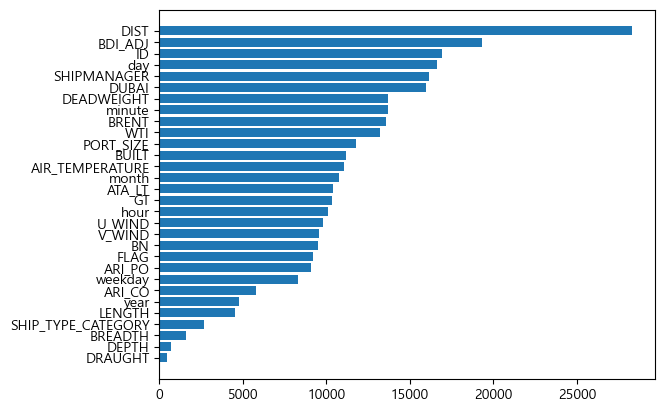

In [13]:
importance = models[-1].get_booster().get_score(importance_type="weight")
tuples = [(k, importance[k]) for k in importance]
tuples.sort(key=lambda x: x[1])

label, values = zip(*tuples)

plt.rcParams["font.family"] = "MalGun Gothic"

plt.barh(label, values)
plt.show()

In [17]:
y_tests

[array([170.93495 , 330.50424 , -23.613998, ..., 166.09526 , 230.13959 ,
        979.2185  ], dtype=float32),
 array([ 117.63971  ,  373.975    ,   80.15301  , ...,    1.0672857,
        -120.85634  , 1028.1959   ], dtype=float32),
 array([  76.54945  ,  218.33952  ,   26.466942 , ...,    2.0445166,
           3.2930694, 1259.9525   ], dtype=float32),
 array([481.65298 , 393.2049  ,  62.06855 , ...,  16.907623,  69.69429 ,
        985.217   ], dtype=float32),
 array([ 188.27316  ,  345.36932  ,    9.309029 , ...,   -1.2347841,
         183.7363   , 1201.864    ], dtype=float32)]

In [19]:
submit = pd.read_csv("./data/sample_submission.csv")
submit["CI_HOUR"] = [i if i > 0 else 0 for i in np.mean(y_tests, axis=0)]
submit.to_csv("./csv/xgboost_optuna.csv", index=False)